# Microbiota Compositional Analysis
## Salmo salar mucosal tissue microbiota across functional feed treatments

#### Load libraries

In [ ]:
set.seed(123)
suppressPackageStartupMessages(library(phyloseq)); packageVersion("phyloseq")
suppressPackageStartupMessages(library(ggplot2)); packageVersion("ggplot2")
suppressPackageStartupMessages(library(dplyr)); packageVersion("dplyr")
suppressPackageStartupMessages(library(vegan)); packageVersion('vegan')
suppressPackageStartupMessages(library(multcomp)); packageVersion('multcomp')
suppressPackageStartupMessages(library(car)); packageVersion('car')
suppressPackageStartupMessages(library(tidyverse)); packageVersion('tidyverse')
suppressPackageStartupMessages(library(viridis))

#### Read in metadata and phyloseq object created in DADA2 notebook

In [2]:
metaDF <- (read.csv('metaDF.csv'))
row.names(metaDF) <- metaDF$SampleID
metaDF <- metaDF[-1]
head(metaDF)

,SampleID,Tank,Fish,Tissue,Diet
,<chr>,<chr>,<chr>,<chr>,<chr>
Diet_Blue1,Diet_Blue1,Diet,Blue1,Diet,Control
Diet_Blue2,Diet_Blue2,Diet,Blue2,Diet,Control
Diet_Green1,Diet_Green1,Diet,Green1,Diet,Coco+MOS
Diet_Green2,Diet_Green2,Diet,Green2,Diet,Coco+MOS
Diet_Orange1,Diet_Orange1,Diet,Orange1,Diet,MOS
Diet_Orange2,Diet_Orange2,Diet,Orange2,Diet,MOS


In [3]:
ps <- readRDS("NCWMAC_ps_wTree.RDS")
ps
sample_data(ps) <- metaDF
ps
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9265 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 4 sample variables ]
tax_table()   Taxonomy Table:    [ 9265 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9265 tips and 9263 internal nodes ]
refseq()      DNAStringSet:      [ 9265 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9265 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 9265 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9265 tips and 9263 internal nodes ]
refseq()      DNAStringSet:      [ 9265 reference sequences ]

#### Write fasta file to run pairwise ASV similarity search with BLASTn upstream of LULU

In [4]:
Biostrings::writeXStringSet(refseq(ps), 'NCWMAC_refSeqs.fasta')

#### Read in results from BLASTn ASV similarity search

In [5]:
matchList <- read.table('ASVmatch_list.txt', sep='\t')
matchList$V3 <- as.numeric(matchList$V3)
head(matchList)

,V1,V2,V3
,<chr>,<chr>,<dbl>
1,ASV1,ASV1,100.000
2,ASV1,ASV6478,99.766
3,ASV1,ASV6193,99.766
4,ASV1,ASV6050,99.766
5,ASV1,ASV6005,99.766
6,ASV1,ASV5978,99.766


#### Run LULU ASV post-clustering

In [6]:
library('lulu')

In [7]:
otuTab <- data.frame(t(otu_table(ps)))

In [8]:
curated_results <- readRDS('LULUcuratedresults.RDS')

In [9]:
ps <- prune_taxa(curated_results$curated_otus, ps)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3240 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3240 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3240 tips and 3239 internal nodes ]
refseq()      DNAStringSet:      [ 3240 reference sequences ]

#### Remove contamination (mitochondria and choloroplast)

In [10]:
ps <- subset_taxa(ps, !is.na(Phylum) 
                  & !Family %in% c('Mitochondria')
                  & !Order %in% c('Chloroplast'))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

#### Analyze Positive Controls

In [11]:
POS <- subset_samples(ps, Tissue == 'Pos')
POS <- prune_taxa(taxa_sums(POS) > 0, POS)
POS <- subset_taxa(POS, !is.na(Genus))
POS <- prune_taxa(taxa_sums(POS) > 0, POS)       
#plot_bar(POS, fill='Genus')
POSr <- transform_sample_counts(POS, function(x) x / sum(x))
POSrGP <- plot_bar(POSr, fill='Genus'
                  ) 

In [12]:
meanPOSr <- psmelt(POSr) %>% dplyr::select(Abundance, Tank, Genus) %>% group_by(Tank,Genus) %>% summarise(Abundance = sum(Abundance)*100) #%>% mutate(Group = paste0(Tank,"_Positive")) #%>% filter(Genus != 'NA')
TruePosComp <- tibble('Genus' = c('Pseudomonas',
                                      'Escherichia/Shigella',
                                      'Salmonella', 
                                      'Lactobacillus', 
                                      'Enterococcus', 
                                      'Staphylococcus',
                                      'Listeria',
                                      'Bacillus'),
                         'Abundance' = c(4.2,
                                        10.1,
                                        10.4,
                                        18.4,
                                        9.9,
                                        15.5,
                                        14.1,
                                        17.4),
                      'Tank' = rep('Theoretical', 8))
POSres <- as.data.frame(rbind(TruePosComp, meanPOSr))
POSres <- POSres %>% mutate(Group=Tank)
POSres$Group <- POSres$Group %>% dplyr::recode(Gill='Pos_1', Gut='Pos_2', Skin='Pos_3')
POSres$Group <- factor(POSres$Group, levels = c('Pos_1', 'Pos_2', 'Pos_3', 'Theoretical'))

`summarise()` has grouped output by 'Tank'. You can override using the `.groups` argument.



In [13]:
POSplot <- ggplot(POSres,aes(x=Group, y=Abundance, fill = Group)) + geom_bar(stat="identity") + facet_wrap('Genus') + ylab('Relative Abundance %') + theme_bw() + theme(axis.title.x = element_blank(),
                                                                                                                                                           axis.text.x = element_blank(),
                                                                                                                                                           axis.ticks.x = element_blank()
                                                                                                                                                           ) + scale_y_continuous(limits=c(0,100), expand=c(0,.8)) 
ggsave('Figures/Manuscript/PosConPlot.png', width=7, height=7, dpi=320, scale=1)

#### Analyze Negative Controls

In [15]:
NTCs <- subset_samples(ps, Tissue == 'NTC')
NTCs <- prune_taxa(taxa_sums(NTCs) > 0, NTCs)
NTC_Tissues = merge_samples(NTCs, "Tank")
#NTCs.fam10 <- microbiome::aggregate_top_taxa(NTCs, "Family", top = 10)
NTCr <- transform_sample_counts(NTC_Tissues, function(x) x / sum(x))
NTCr.fam10 <- microbiome::aggregate_top_taxa(NTCr, "Genus", top = 20)

Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”


In [16]:
mean(sample_sums(NTCs))
sd(sample_sums(NTCs))

[1] 2845

[1] 1452.828

In [17]:
#plot_bar(NTCs, fill='Family')
NTCplot <- plot_bar(NTCr.fam10, fill='Genus') + theme_bw() + theme(axis.text.x = element_blank(),
                            axis.ticks = element_blank()
                           ) + scale_y_continuous( limits = c(0,1.01),expand = c(0, 0)) + xlab('') 
ggsave('Figures/Manuscript/NegConPlot.png', width=7, height=7, dpi=320, scale=1)

Saving 7 x 7 in image



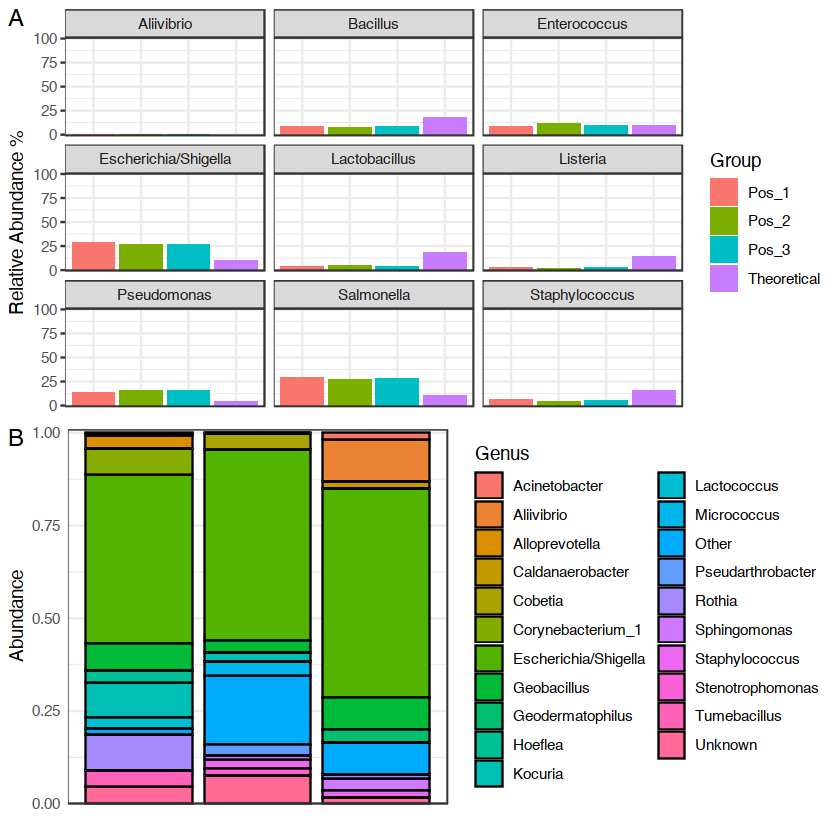

In [18]:
ggpubr::ggarrange(POSplot, NTCplot, ncol=1, labels="AUTO")
ggsave('Figures/Manuscript/PosNegControlPlots.png')

# Remove controls

In [19]:
psNCBISamps <- prune_samples(sample_data(ps)$Tissue %in% c('Gut', 'Gill', 'Skin','Diet', 'Water'), ps)
psNCBISamps
saveRDS(psNCBISamps, 'psNCBISamps.RDS')

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 226 samples ]
sample_data() Sample Data:       [ 226 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

In [20]:
table(sample_data(ps)$Tissue)
table(sample_data(psNCBISamps)$Tissue)


 Diet  Gill   Gut   NTC   Pos  Skin Water 
    8    72    71    11     3    72     3 


 Diet  Gill   Gut  Skin Water 
    8    72    71    72     3 

### Create sub datasets

In [21]:
psFish <- prune_samples(sample_data(ps)$Tissue %in% c('Gut', 'Gill', 'Skin'), ps)
psFish
psControls <- prune_samples(sample_data(ps)$Diet %in% c('Positive', 'Negative'), ps)
psControls
psDietWater <- prune_samples(sample_data(ps)$Tank %in% c('Diet', 'Water'), ps)
psDietWater

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 215 samples ]
sample_data() Sample Data:       [ 215 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 11 samples ]
sample_data() Sample Data:       [ 11 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

In [22]:
psDiet <- prune_samples(sample_data(ps)$Tank == 'Diet', ps)
psDiet <- filter_taxa(psDiet, function(x) sum(x) > 2, TRUE)
psDiet
                      
psWater <- prune_samples(sample_data(ps)$Tank == 'Water', ps)
psWater <- filter_taxa(psWater, function(x) sum(x) > 2, TRUE)
psWater                      

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 265 taxa and 8 samples ]
sample_data() Sample Data:       [ 8 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 265 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 265 tips and 264 internal nodes ]
refseq()      DNAStringSet:      [ 265 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 637 taxa and 3 samples ]
sample_data() Sample Data:       [ 3 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 637 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 637 tips and 636 internal nodes ]
refseq()      DNAStringSet:      [ 637 reference sequences ]

In [23]:
psFish <- filter_taxa(psFish, function(x) sum(x) >= 1, TRUE)
psFish
psControls <- filter_taxa(psControls, function(x) sum(x) >= 1, TRUE)
psControls
psDietWater <- filter_taxa(psDietWater, function(x) sum(x) >= 1, TRUE)
psDietWater

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2972 taxa and 215 samples ]
sample_data() Sample Data:       [ 215 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2972 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2972 tips and 2971 internal nodes ]
refseq()      DNAStringSet:      [ 2972 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 80 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 80 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 80 tips and 79 internal nodes ]
refseq()      DNAStringSet:      [ 80 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 936 taxa and 11 samples ]
sample_data() Sample Data:       [ 11 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 936 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 936 tips and 935 internal nodes ]
refseq()      DNAStringSet:      [ 936 reference sequences ]

In [24]:
levels(sample_data(psFish)$Diet)
sample_data(psFish)$Diet <- factor(sample_data(psFish)$Diet, levels=c("Control","MOS","CoconutOil", "Coco+MOS"))
levels(sample_data(psFish)$Diet)

NULL

[1] "Control"    "MOS"        "CoconutOil" "Coco+MOS"

#### Remove bad samples (<= 24182 reads) and spurious ASVs (< 0.00001% abundance)

In [25]:
mean(sample_sums(psFish))
sd(sample_sums(psFish))
range(sample_sums(psFish))
tail(sort(sample_sums(psFish), decreasing = TRUE), 10)

[1] 48746.44

[1] 24316.46

[1]     20 157812

T7_F1_Skin T20_F3_Skin  T9_F1_Skin  T6_F2_Skin  T22_F2_Gut   T9_F3_Gut 
      25333       25072       24794       24182         181         134 
T24_F2_Gill  T24_F3_Gut  T7_F3_Gill  T8_F3_Gill 
         71          49          32          20

In [26]:
psFish1 <- prune_samples(sample_sums(psFish)>=24180, psFish)
psFish1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2972 taxa and 209 samples ]
sample_data() Sample Data:       [ 209 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2972 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2972 tips and 2971 internal nodes ]
refseq()      DNAStringSet:      [ 2972 reference sequences ]

In [27]:
table(sample_data(psFish1)$Diet)
table(sample_data(psFish1)$Tissue)


   Control        MOS CoconutOil   Coco+MOS 
        53         54         54         48 


Gill  Gut Skin 
  69   68   72 

#### Dropped 4 gut (1 gut sample already removed) and 3 gill samples overall

In [28]:
mean(sample_sums(psFish1))
sd(sample_sums(psFish1))
range(sample_sums(psFish1))
tail(sort(sample_sums(psFish1), decreasing = TRUE), 5)

[1] 50143.53

[1] 23196.31

[1]  24182 157812

T8_F3_Skin  T7_F1_Skin T20_F3_Skin  T9_F1_Skin  T6_F2_Skin 
      25765       25333       25072       24794       24182

In [29]:
psFish1r  <- transform_sample_counts(psFish1, function(x) x / sum(x))
psFish1rf <- filter_taxa(psFish1r, function(x) mean(x) > 1e-5, TRUE)
psFish1rf # relative abundance
saveRDS(psFish1rf, 'psFish1rf.RDS')
                         
psFish1f <- prune_taxa(taxa_names(psFish1rf), psFish1)
psFish1f # absolute count
saveRDS(psFish1f, 'psFish1f.RDS')                    

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 209 samples ]
sample_data() Sample Data:       [ 209 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 209 samples ]
sample_data() Sample Data:       [ 209 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

#### Write FASTA and otu table for PICRUST2

In [112]:
Biostrings::writeXStringSet(refseq(psFish1f), 'PICRUST/Fish1f_refSeqs.fasta')
write.table(t(otu_table(psFish1f)), sep='\t', 'PICRUST/Fish1f_otutab.txt', quote = FALSE, col.names =NA)

### Beta diversity

#### Run unifrac and plot beta diversity

In [30]:
set.seed(123)
allFish.wUn.Dist <- distance(psFish1rf, method = "wunifrac")
saveRDS(allFish.wUn.Dist, 'fish_weightedUniFrac_Dist.RDS')
allFish.uwUn.Dist <- distance(psFish1rf, method = "unifrac")
saveRDS(allFish.uwUn.Dist, 'fish_unweightedUniFrac_Dist.RDS')

In [31]:
allFish.wUn.ord <- ordinate(psFish1rf, method = "PCoA", allFish.wUn.Dist)
saveRDS(allFish.wUn.ord, 'fish_weightedUniFrac_PCoAord.RDS')
allFish.uwUn.ord <- ordinate(psFish1rf, method = "PCoA", allFish.uwUn.Dist)
saveRDS(allFish.uwUn.ord, 'fish_unweightedUniFrac_PCoAord.RDS')

In [32]:
myTheme <- theme(plot.title = element_text(hjust = 0.5, size=15),
                 axis.title = element_text(hjust = 0.5, size=15),
                 axis.text = element_text(size=15))

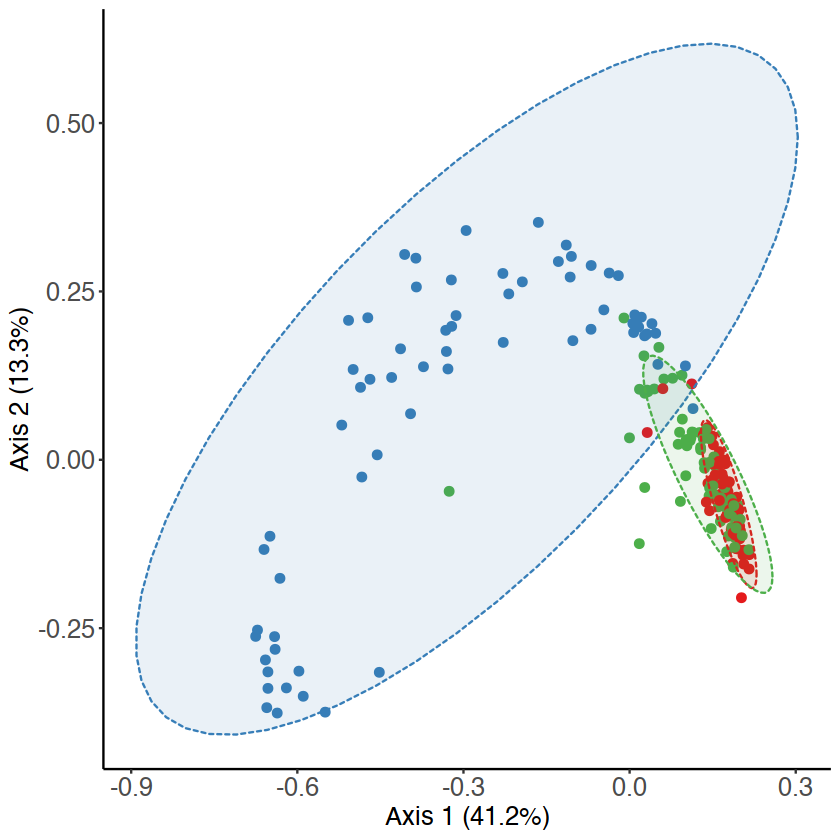

In [33]:
p1wUni = plot_ordination(psFish1rf, allFish.wUn.ord, type="samples", color="Tissue") #, shape="Diet")
p1wUni  <- p1wUni  + geom_point(aes(size=2), alpha=1, size=2
                #) + facet_grid("Tissue"
                              ) + stat_ellipse(geom='polygon', 
                                               linetype = 2, 
                                               alpha=0.1, 
                                               aes(fill=Tissue, group=Tissue, color=Tissue)
                                              ) + theme_classic() + myTheme + xlab('Axis 1 (41.2%)'
                                                                                  ) + ylab('Axis 2 (13.3%)'
                                                                                          ) + theme(legend.position='blank')+ scale_color_brewer(palette = 'Set1', type='div')+ scale_fill_brewer(palette = 'Set1', type='div')
p1wUni

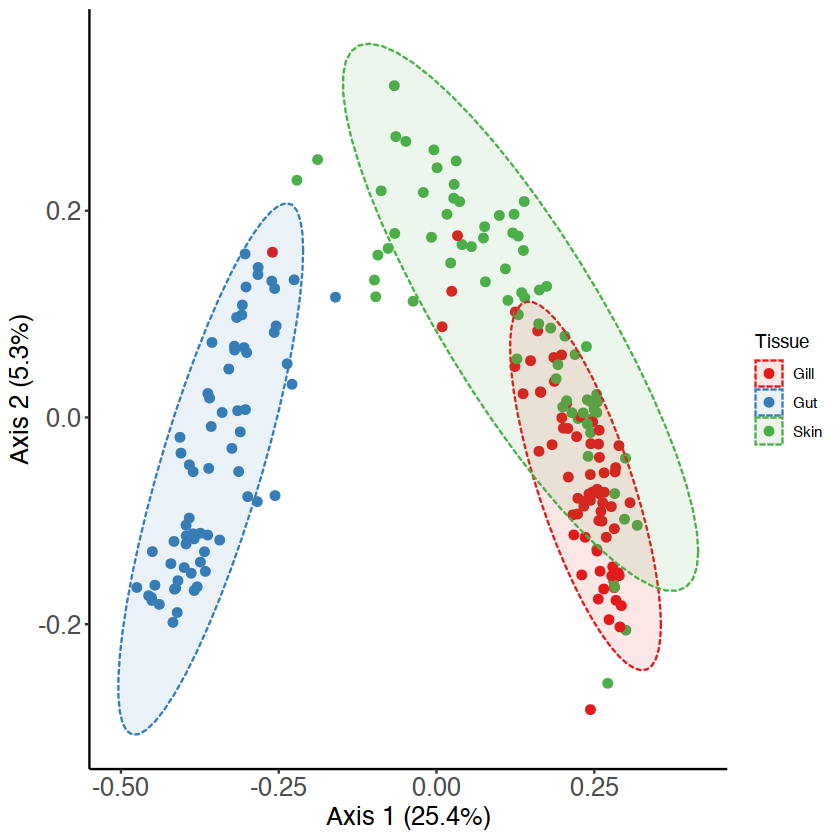

In [34]:
p1uwUni = plot_ordination(psFish1rf, allFish.uwUn.ord, type="samples", color="Tissue")#, shape="Diet")
p1uwUni <- p1uwUni + geom_point(aes(size=2), alpha=1, size=2
                        #) + facet_grid("Tissue"
                                      ) + stat_ellipse(geom='polygon', linetype = 2, alpha=0.1, aes(fill=Tissue, group=Tissue)) + theme_classic() + myTheme + xlab('Axis 1 (25.4%)'
                                                                                                                                                 ) + ylab('Axis 2 (5.3%)'
                                                                                                                                                 ) + scale_color_brewer(palette = 'Set1', type='div') + scale_fill_brewer(palette = 'Set1', type='div')
p1uwUni 

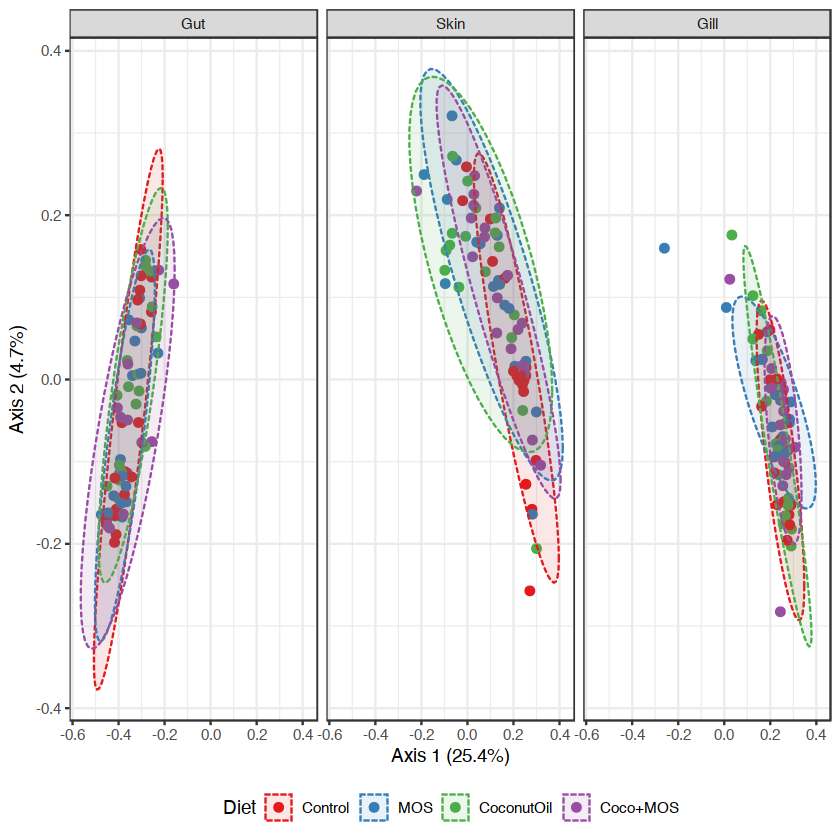

In [35]:
p2uw = plot_ordination(psFish1rf, allFish.uwUn.ord, type="samples", color="Diet")#, shape="Tissue")
p2uw$data$Tissue <- factor(p2uw$data$Tissue, levels=c('Gut', 'Skin', 'Gill'))
p2uw <- p2uw + geom_point(aes(size=2), alpha=1, size=2
                ) + facet_wrap("Tissue"
                              ) + stat_ellipse(geom='polygon', linetype = 2, alpha=0.1, aes(group=Diet, fill=Diet)) + theme_bw() + myTheme + xlab('Axis 1 (25.4%)'
                                                                                           ) + ylab('Axis 2 (4.7%)'
                                                                                                ) + theme_bw() + theme(legend.position='bottom') + scale_color_brewer(palette = 'Set1', type='div') + scale_fill_brewer(palette = 'Set1', type='div') 
p2uw
#ggsave('Figures/FacetedDiet_uwUniFracMDS.pdf', width=8, height=10, scale=.7)

#### Test multivariate dispersion of full dataset - tissue does not have homogeneity of variance

In [36]:
metaDict <- as(sample_data(psFish1rf), "data.frame")
tissueGroups <- metaDict[["Tissue"]]
DietGroups <- metaDict[["Diet"]]

In [37]:
modTuwUni <- betadisper(allFish.uwUn.Dist, tissueGroups)
anova(modTuwUni)
modDuwUni <- betadisper(allFish.uwUn.Dist, DietGroups)
anova(modDuwUni)

modTwUni <- betadisper(allFish.wUn.Dist, tissueGroups)
anova(modTwUni)
modTwUni <- betadisper(allFish.wUn.Dist, DietGroups)
anova(modTwUni)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,2,0.1159793,0.057989643,26.57982,5.381278e-11
Residuals,206,0.4494337,0.002181717,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.00515122,0.001717073,0.3907353,0.7597969
Residuals,205,0.90086578,0.004394467,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,2,2.713420,1.356710049,167.0357,7.688827e-44
Residuals,206,1.673189,0.008122278,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.05271773,0.01757258,0.4612863,0.7096268
Residuals,205,7.80941967,0.03809473,NA,NA


#### Run global and pairwise PERMANOVA on weighted UniFrac

In [38]:
perm <- how(nperm = 999)
setBlocks(perm) <- with(metaDict, Tank)
adonis2(allFish.wUn.Dist ~ Tissue*Diet, data=metaDict, permutations = perm) 

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tissue,2,11.629872,0.31224392,46.904612,0.001
Diet,3,0.403425,0.01083133,1.084706,0.001
Tissue:Diet,6,0.790006,0.02121043,1.062062,0.400
Residual,197,24.422810,0.65571432,NA,NA
Total,208,37.246113,1.00000000,NA,NA


In [39]:
library(RVAideMemoire)
pairwise.perm.manova(allFish.wUn.Dist, metaDict$Tissue)
pairwise.perm.manova(allFish.wUn.Dist, metaDict$Diet)

Warning message:
“package ‘RVAideMemoire’ was built under R version 4.0.2”
*** Package RVAideMemoire v 0.9-80 ***




	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  allFish.wUn.Dist by metaDict$Tissue
999 permutations 

     Gill  Gut  
Gut  0.001 -    
Skin 0.001 0.001

P value adjustment method: fdr 


	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  allFish.wUn.Dist by metaDict$Diet
999 permutations 

           Control MOS  CoconutOil
MOS        0.74    -    -         
CoconutOil 0.74    0.74 -         
Coco+MOS   0.74    0.74 0.74      

P value adjustment method: fdr 

#### Run global and pairwise PERMANOVA on unweighted UniFrac

In [40]:
adonis2(allFish.uwUn.Dist ~ Tissue * Diet, data=metaDict, permutations = perm) 

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tissue,2,14.4753139,0.23021787,31.057937,0.001
Diet,3,0.8667303,0.01378463,1.239759,0.001
Tissue:Diet,6,1.6261992,0.02586335,1.163047,0.164
Residual,197,45.9083435,0.73013415,NA,NA
Total,208,62.8765869,1.00000000,NA,NA


In [41]:
pairwise.perm.manova(allFish.uwUn.Dist, metaDict$Tissue)
pairwise.perm.manova(allFish.uwUn.Dist, metaDict$Diet)


	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  allFish.uwUn.Dist by metaDict$Tissue
999 permutations 

     Gill  Gut  
Gut  0.001 -    
Skin 0.001 0.001

P value adjustment method: fdr 


	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  allFish.uwUn.Dist by metaDict$Diet
999 permutations 

           Control MOS  CoconutOil
MOS        0.72    -    -         
CoconutOil 0.72    0.80 -         
Coco+MOS   0.76    0.72 0.72      

P value adjustment method: fdr 

### Generate tissue specific datasets for beta diversity

In [42]:
psGut <- prune_samples(sample_data(psFish1f)$Tissue %in% c('Gut'), psFish1f)
psGut
psGill <- prune_samples(sample_data(psFish1f)$Tissue %in% c('Gill'), psFish1f)
psGill
psSkin <- prune_samples(sample_data(psFish1f)$Tissue %in% c('Skin'), psFish1f)
psSkin

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 69 samples ]
sample_data() Sample Data:       [ 69 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

In [43]:
psGut <- filter_taxa(psGut, function(x) sum(x) > 1, TRUE)
psGut
psGill <- filter_taxa(psGill, function(x) sum(x) > 1, TRUE)
psGill
psSkin <- filter_taxa(psSkin, function(x) sum(x) > 1, TRUE)
psSkin

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 448 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 448 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 448 tips and 447 internal nodes ]
refseq()      DNAStringSet:      [ 448 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1818 taxa and 69 samples ]
sample_data() Sample Data:       [ 69 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 1818 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1818 tips and 1817 internal nodes ]
refseq()      DNAStringSet:      [ 1818 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1604 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 1604 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1604 tips and 1603 internal nodes ]
refseq()      DNAStringSet:      [ 1604 reference sequences ]

#### Test beta dispersion diet within gut tissue

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.08553969,0.02851323,1.841545,0.1485328
Residuals,64,0.99093256,0.01548332,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.0008741684,0.0002913895,0.1416456,0.9346485
Residuals,64,0.1316590306,0.0020571724,NA,NA


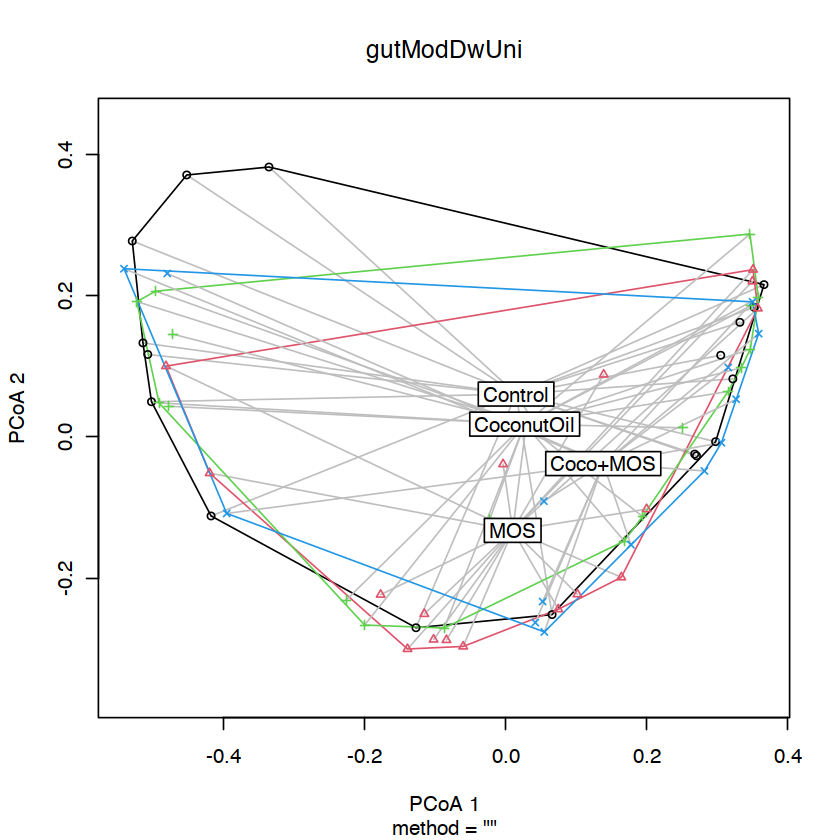

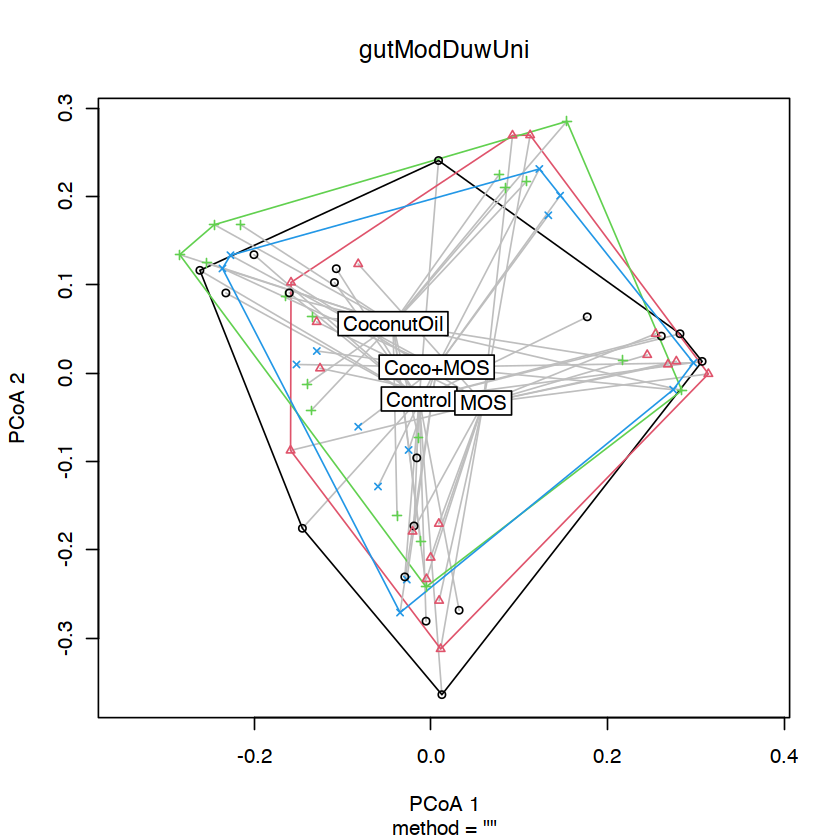

In [44]:
psGutr  <- transform_sample_counts(psGut, function(x) x / sum(x))
gutDict <- as(sample_data(psGutr), "data.frame")
GutDietGroups <- gutDict[["Diet"]]
            
set.seed(123)                                   
psGutrDistWuni <- distance(psGutr, method='wunifrac')
psGutrDistUWuni <- distance(psGutr, method='uunifrac')
                                   
gutModDwUni <- betadisper(psGutrDistWuni, GutDietGroups)
anova(gutModDwUni)
plot(gutModDwUni) 
                                   
gutModDuwUni <- betadisper(psGutrDistUWuni, GutDietGroups)
anova(gutModDuwUni)
plot(gutModDuwUni)                                     

#### Test gut for dietary effects - PERMANOVA

In [45]:
perm <- how(nperm = 999)
setBlocks(perm) <- with(gutDict, Tank)
adonis2(psGutrDistWuni ~ Diet + Diet, data=gutDict, permutations = perm)                                   
adonis2(psGutrDistUWuni ~ Diet+ Diet, data=gutDict, permutations = perm)   

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.7263413,0.04423581,0.9873746,1
Residual,64,15.6934165,0.95576419,NA,NA
Total,67,16.4197578,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.8070155,0.04805084,1.076827,1
Residual,64,15.9880204,0.95194916,NA,NA
Total,67,16.7950359,1.00000000,NA,NA


#### Test betadispersion of diet within gill tissue

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.001750369,0.0005834565,0.2301556,0.8750675
Residuals,65,0.164778408,0.0025350524,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.005559366,0.001853122,0.6746048,0.5707188
Residuals,65,0.178553327,0.002746974,NA,NA


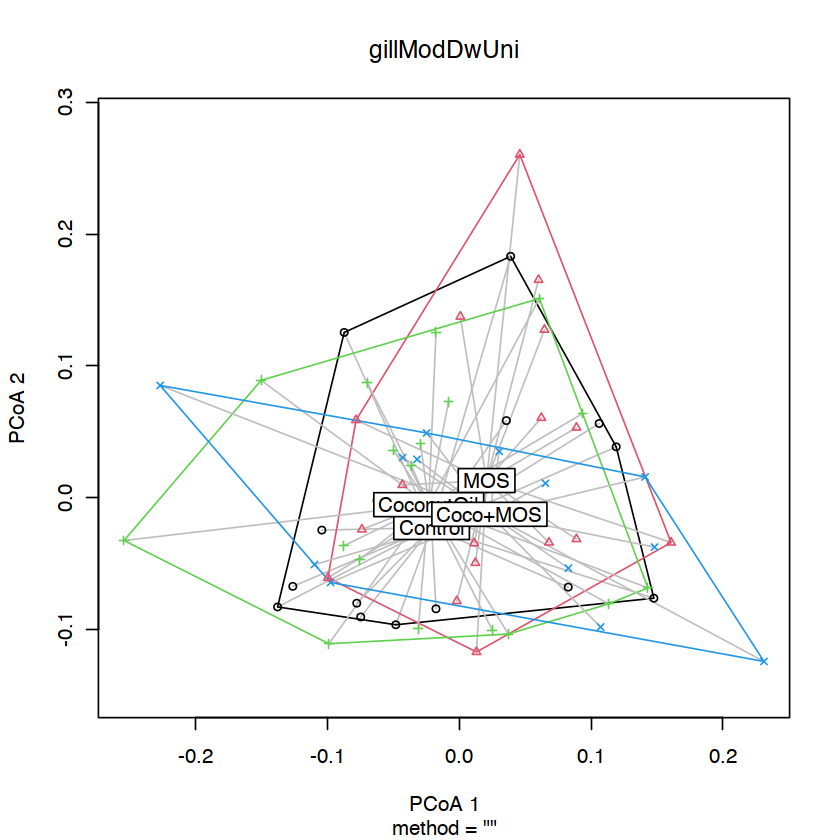

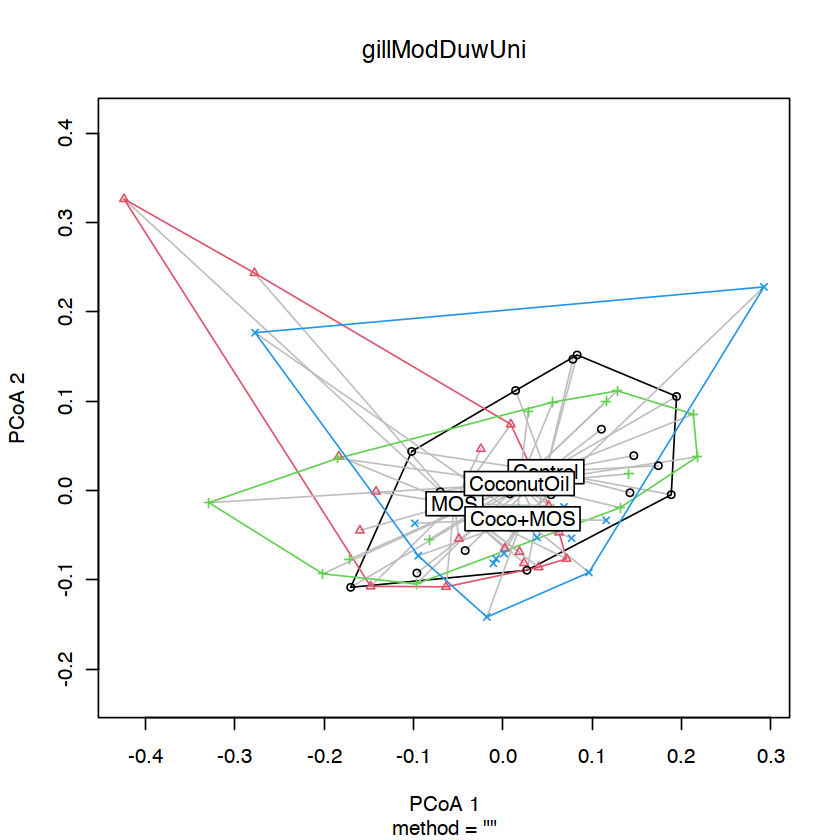

In [46]:
psGillr  <- transform_sample_counts(psGill, function(x) x / sum(x))
gillDict <- as(sample_data(psGillr), "data.frame")
GillDietGroups <- gillDict[["Diet"]]

set.seed(123)
psGillDistWuni <- distance(psGillr, method='wunifrac')
psGillDistUWuni <- distance(psGillr, method='uunifrac')
                                    
gillModDwUni <- betadisper(psGillDistWuni, GillDietGroups)
anova(gillModDwUni)
plot(gillModDwUni)
gillModDuwUni <- betadisper(psGillDistUWuni, GillDietGroups)
anova(gillModDuwUni)
plot(gillModDuwUni)                                       

#### Test gill for dietary effects - PERMANOVA

In [47]:
perm <- how(nperm = 999)
setBlocks(perm) <- with(gillDict, Tank)                                    
adonis2(psGillDistWuni ~ Diet, data=gillDict, permutations = perm) 
adonis2(psGillDistUWuni ~ Diet, data=gillDict, permutations = perm)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.1601704,0.0496723,1.132486,1
Residual,65,3.0643704,0.9503277,NA,NA
Total,68,3.2245408,1.0000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.6447216,0.04660134,1.059049,1
Residual,65,13.1901088,0.95339866,NA,NA
Total,68,13.8348304,1.00000000,NA,NA


#### Test betadispersion of diet within skin tissue

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.02249094,0.007496980,0.9090826,0.4413407
Residuals,68,0.56077925,0.008246754,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.006681918,0.002227306,1.075612,0.3653407
Residuals,68,0.140809858,0.002070733,NA,NA


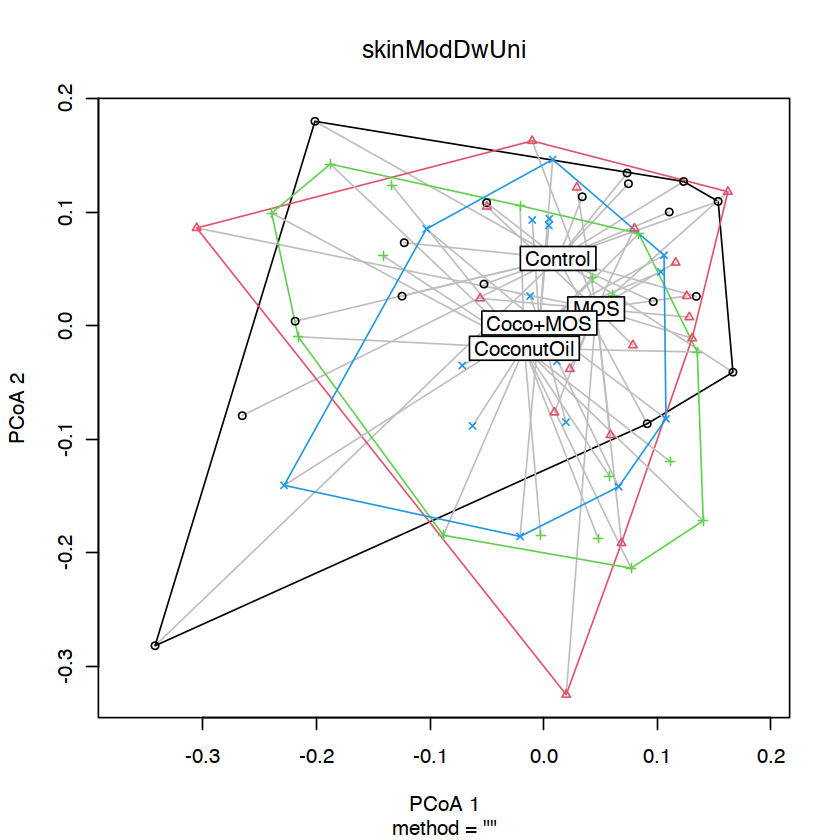

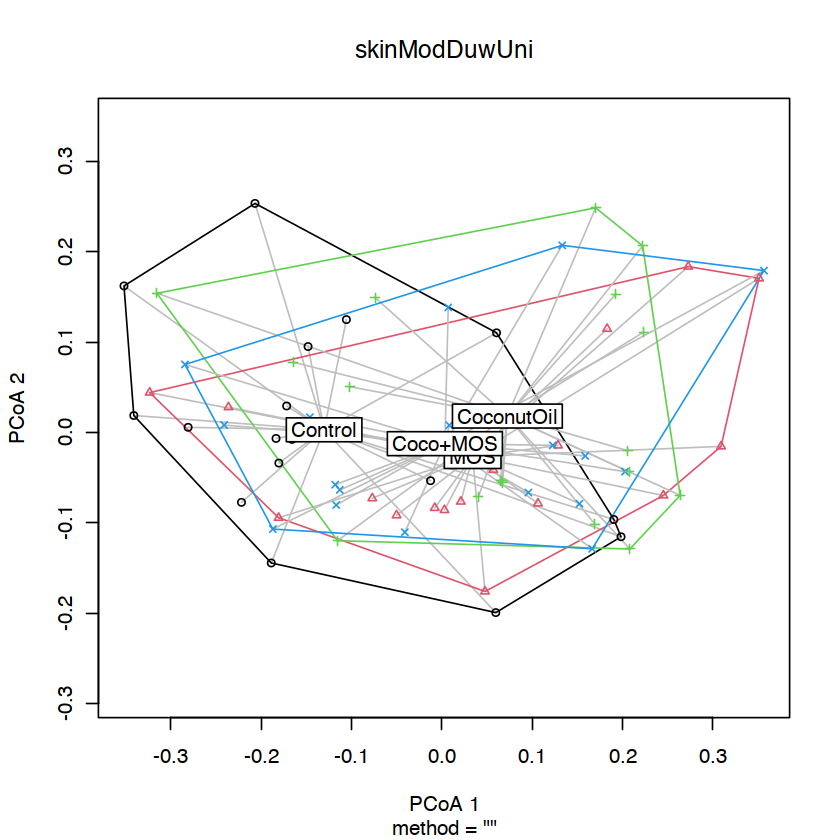

In [48]:
psSkinr  <- transform_sample_counts(psSkin, function(x) x / sum(x))
skinDict <- as(sample_data(psSkinr), "data.frame")
SkinDietGroups <- skinDict[["Diet"]]
                                   
set.seed(123)
psSkinDistWuni <- distance(psSkinr, method='wunifrac')
psSkinDistUWuni <- distance(psSkinr, method='uunifrac')
                                    
skinModDwUni <- betadisper(psSkinDistWuni, SkinDietGroups)
anova(skinModDwUni)
plot(skinModDwUni)
skinModDuwUni <- betadisper(psSkinDistUWuni, SkinDietGroups)
anova(skinModDuwUni)
plot(skinModDuwUni)                                                     

#### Test skin for dietary effects - PERMANOVA

In [49]:
perm <- how(nperm = 999)
setBlocks(perm) <- with(skinDict, Tank)                                    
adonis2(psSkinDistWuni ~ Diet, data=skinDict, permutations = perm)
adonis2(psSkinDistUWuni ~ Diet, data=skinDict, permutations = perm) 

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.3069193,0.05139355,1.228033,1
Residual,68,5.6650229,0.94860645,NA,NA
Total,71,5.9719422,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,1.041192,0.05858806,1.410643,1
Residual,68,16.730214,0.94141194,NA,NA
Total,71,17.771407,1.00000000,NA,NA


## Differential abundance testing using DESeq2

In [50]:
ddsFish <- phyloseq_to_deseq2(psFish1f, ~ Tissue * Diet)
ddsFish$Tissue <- factor(ddsFish$Tissue, levels=c('Gut', 'Skin', 'Gill'))
ddsFish$Diet <- factor(ddsFish$Diet, levels=c('Control', 'MOS', 'CoconutOil', 'Coco+MOS'))
ddsFish <- DESeq2::estimateSizeFactors(ddsFish, type='poscount')
ddsFish <- DESeq2::estimateDispersions(ddsFish, fitType = "local")
ddsFish <- DESeq2::DESeq(ddsFish)

Loading required namespace: DESeq2

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but 

In [51]:
DESeq2::resultsNames(ddsFish)

[1] "Intercept"                  "Tissue_Skin_vs_Gut"        
 [3] "Tissue_Gill_vs_Gut"         "Diet_MOS_vs_Control"       
 [5] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"  
 [7] "TissueSkin.DietMOS"         "TissueGill.DietMOS"        
 [9] "TissueSkin.DietCoconutOil"  "TissueGill.DietCoconutOil" 
[11] "TissueSkin.DietCoco.MOS"    "TissueGill.DietCoco.MOS"

In [52]:
skinVgut <- DESeq2::lfcShrink(ddsFish, coef = 'Tissue_Skin_vs_Gut', type='apeglm')
sum(skinVgut$padj < 0.05, na.rm=TRUE)
summary(skinVgut)
skinVgutRes <- subset(skinVgut, padj <= 0.05 & abs(log2FoldChange) >= 1)
skinVgutFilt <- skinVgutRes[ order(skinVgutRes$log2FoldChange), ]
nrow(skinVgutFilt)
skinVgutFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 310

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 50

log2 fold change (MAP): Tissue Skin vs Gut 
Wald test p-value: Tissue Skin vs Gut 
DataFrame with 50 rows and 5 columns
       baseMean log2FoldChange     lfcSE      pvalue        padj
      <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ASV27   110.731       -9.75642  4.306931 8.87353e-23 2.58057e-21
ASV2  16166.197       -3.33894  0.647439 9.72615e-09 9.89983e-08
ASV1  24719.689       -3.33639  0.577793 3.16374e-10 3.68793e-09
ASV4   3326.750       -2.59751  1.068139 3.37207e-04 1.96934e-03
ASV52   108.943        3.77242  2.422949 5.79588e-03 2.67286e-02
...         ...            ...       ...         ...         ...
ASV57    79.601        15.0533   4.21203 1.03469e-38 7.02109e-37
ASV24   233.546        15.4478   3.32502 1.81601e-59 2.87535e-57
ASV39   116.704        16.2421   3.72618 1.55389e-80 7.38096e-78
ASV26   181.011        16.5670   3.74775 2.09360e-73 7.45845e-71
ASV17   292.303        16.7571   3.08345 1.34227e-27 5.31316e-26

In [53]:
gillVgut <- DESeq2::lfcShrink(ddsFish, coef = 'Tissue_Gill_vs_Gut', type='apeglm')
sum(gillVgut$padj < 0.05, na.rm=TRUE)
summary(gillVgut)
gillVgutRes <- subset(gillVgut, padj <= 0.05 & abs(log2FoldChange) >= 1)
gillVgutFilt <- gillVgutRes[ order(gillVgutRes$log2FoldChange), ]
nrow(gillVgutFilt)
gillVgutFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 267

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 59

log2 fold change (MAP): Tissue Gill vs Gut 
Wald test p-value: Tissue Gill vs Gut 
DataFrame with 59 rows and 5 columns
         baseMean log2FoldChange     lfcSE      pvalue        padj
        <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ASV1   24719.6885       -3.37031  0.587711 3.65796e-10 4.41745e-09
ASV4    3326.7499       -2.62752  1.096407 3.33465e-04 2.20204e-03
ASV10    769.8512        3.83036  1.585261 3.87544e-04 2.54493e-03
ASV42    120.0689        8.20291  1.696767 1.23924e-08 1.27044e-07
ASV304    22.6142        9.29269  8.602587 2.14815e-12 3.09203e-11
...           ...            ...       ...         ...         ...
ASV20     327.105        15.9409   3.17251 5.41517e-71 1.92915e-68
ASV40     132.967        16.0290   3.84049 2.22926e-60 3.17670e-58
ASV15     413.452        16.4914   2.97194 6.00519e-95 4.27870e-92
ASV30     161.680        16.5540   4.03444 1.29128e-50 1.31434e-48
ASV28     192.508        16.7585   3.89170 1.41206e-61 2.23576e-59

#### Relevel to get skin vs gill comparison

In [54]:
ddsFish$Tissue <- relevel(ddsFish$Tissue, "Gill")
ddsFish_Gill <- DESeq2::DESeq(ddsFish, fitType='local')
DESeq2::resultsNames(ddsFish_Gill)

skinVgill <- DESeq2::lfcShrink(ddsFish_Gill, coef = 'Tissue_Skin_vs_Gill', type='apeglm')
sum(skinVgill$padj < 0.05, na.rm=TRUE)
summary(skinVgill)
skinVgillRes <- subset(skinVgill, padj <= 0.05 & abs(log2FoldChange) >= 1)
skinVgillFilt <- skinVgillRes[ order(skinVgillRes$log2FoldChange), ]
nrow(skinVgillFilt)
skinVgillFilt

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

fitting model and testing

1 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest

  Note: levels of factors in the design contain charac

[1] "Intercept"                  "Tissue_Gut_vs_Gill"        
 [3] "Tissue_Skin_vs_Gill"        "Diet_MOS_vs_Control"       
 [5] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"  
 [7] "TissueGut.DietMOS"          "TissueSkin.DietMOS"        
 [9] "TissueGut.DietCoconutOil"   "TissueSkin.DietCoconutOil" 
[11] "TissueGut.DietCoco.MOS"     "TissueSkin.DietCoco.MOS"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 70

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 1

log2 fold change (MAP): Tissue Skin vs Gill 
Wald test p-value: Tissue Skin vs Gill 
DataFrame with 1 row and 5 columns
       baseMean log2FoldChange     lfcSE      pvalue        padj
      <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ASV46   44.8299       -9.41827   6.09546 2.22821e-15 6.63265e-13

#### Venn diagram of differential tissue ASVs

Loading required package: gplots

Warning message:
“package ‘gplots’ was built under R version 4.0.2”

Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




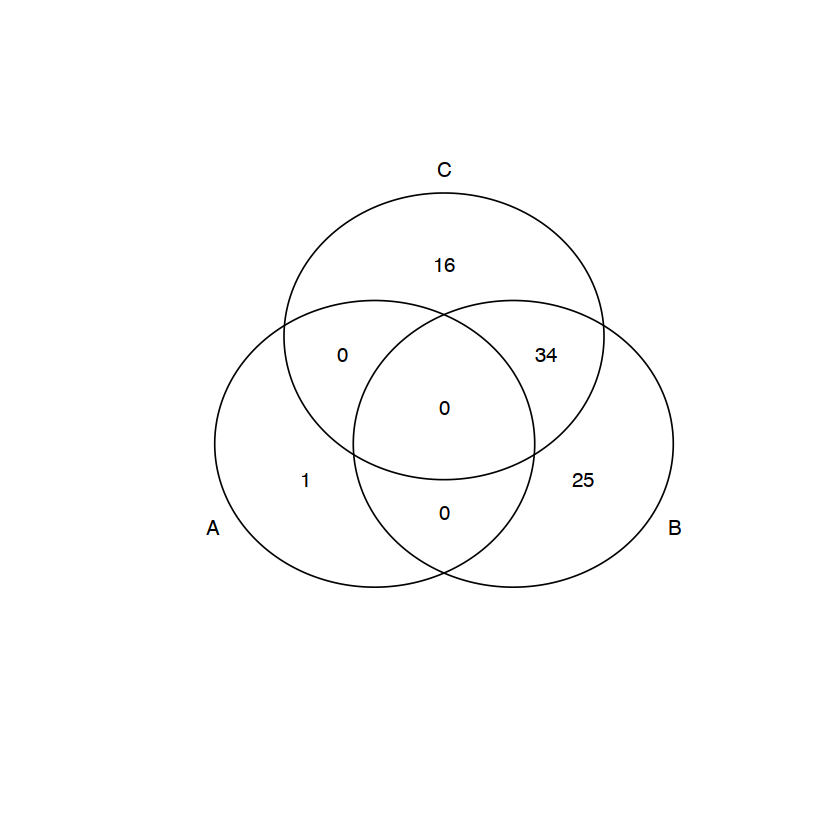

In [55]:
sigskinVgill <- row.names(skinVgillFilt)
siggillVgut <- row.names(gillVgutFilt)
sigskinVgut <- row.names(skinVgutFilt)

require(gplots)
venn(list(sigskinVgill,
          siggillVgut,
          sigskinVgut))

In [56]:
library(VennDiagram)
tiff('Figures/Manuscript/Tissue_DAMs.tiff')
IHN_DTGs <- draw.triple.venn(area1 = 1, 
                             area2 = 58,
                             area3= 44,
                             n12 = 0,
                             n23 = 30,
                             n13 = 0,
                             n123 = 0,
                             category = c('Skin vs. Gill', 'Gill vs. Gut', 'Skin vs. Gut'),
                             fill = c('seagreen',"turquoise","sienna"),
                             #alpha = rep(0.5, 2),
                             cat.pos = c(0, 0, 0),
                             #cat.dist = rep(-0.03, 3),
                             cex = 1,
                             cat.cex = 1,
                             scaled = F,
                             cat.default.pos='text')
dev.off()

Warning message:
“package ‘VennDiagram’ was built under R version 4.0.2”
Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘VennDiagram’


The following object is masked from ‘package:car’:

    ellipse




pdf 
  2

### Global dietary effects - differential abundance

In [57]:
mosVcont <- DESeq2::lfcShrink(ddsFish, coef = 'Diet_MOS_vs_Control', type='apeglm')
sum(mosVcont$padj < 0.05, na.rm=TRUE)
summary(mosVcont)
mosVcontRes <- subset(mosVcont, padj <= 0.05 & abs(log2FoldChange) >= 1)
mosVcontFilt <- mosVcontRes[ order(mosVcontRes$log2FoldChange), ]
nrow(mosVcontFilt)
mosVcontFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 116

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet MOS vs Control 
Wald test p-value: Diet MOS vs Control 
DataFrame with 0 rows and 5 columns

In [58]:
cocoVcont <- DESeq2::lfcShrink(ddsFish, coef = 'Diet_CoconutOil_vs_Control', type='apeglm')
sum(cocoVcont$padj < 0.05, na.rm=TRUE)
summary(cocoVcont)
cocoVcontRes <- subset(cocoVcont, padj <= 0.05 & abs(log2FoldChange) >= 1)
cocoVcontFilt <- cocoVcontRes[ order(cocoVcontRes$log2FoldChange), ]
nrow(cocoVcontFilt)
cocoVcontFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 106

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

In [59]:
cocomosVcont <- DESeq2::lfcShrink(ddsFish, coef = 'Diet_CoconutOil_vs_Control', type='apeglm')
sum(cocomosVcont$padj < 0.05, na.rm=TRUE)
summary(cocomosVcont)
cocomosVcontRes <- subset(cocomosVcont, padj <= 0.05 & abs(log2FoldChange) >= 1)
cocomosVcontFilt <- cocomosVcontRes[ order(cocoVcontRes$log2FoldChange), ]
nrow(cocomosVcontFilt)
cocomosVcontFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 106

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

#### Now tissue-specific effects of diet

In [ ]:
ddsSkin <- phyloseq_to_deseq2(psSkin, ~ Diet)
ddsSkin$Diet <- factor(ddsSkin$Diet, levels=c('Control', 'MOS', 'CoconutOil', 'Coco+MOS'))
ddsSkin <- DESeq2::estimateSizeFactors(ddsSkin) #, type='poscount'
ddsSkin <- DESeq2::estimateDispersions(ddsSkin) #, fitType = "local"
ddsSkin <- DESeq2::DESeq(ddsSkin)

In [61]:
DESeq2::resultsNames(ddsSkin)

[1] "Intercept"                  "Diet_MOS_vs_Control"       
[3] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"

In [62]:
conVmosS <- DESeq2::lfcShrink(ddsSkin, coef = 'Diet_MOS_vs_Control', type='apeglm')
sum(conVmosS$padj < 0.05, na.rm=TRUE)
summary(conVmosS)
conVmosSRes <- subset(conVmosS, padj < 0.05 & abs(log2FoldChange) >= 1)
conVmosSFilt <- conVmosSRes[ order(conVmosSRes$log2FoldChange), ]
nrow(conVmosSFilt)
conVmosSFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 50

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet MOS vs Control 
Wald test p-value: Diet MOS vs Control 
DataFrame with 0 rows and 5 columns

In [63]:
conVcocoS <- DESeq2::lfcShrink(ddsSkin, coef ='Diet_CoconutOil_vs_Control', type='apeglm')
sum(conVcocoS$padj < 0.05, na.rm=TRUE)
summary(conVcocoS)
conVcocoSRes <- subset(conVcocoS, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocoSFilt <- conVcocoSRes[ order(conVcocoSRes$log2FoldChange), ]
nrow(conVcocoSFilt)
conVcocoSFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 62

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

In [64]:
conVcocomosS <- DESeq2::lfcShrink(ddsSkin, coef ='Diet_Coco.MOS_vs_Control', type='apeglm')
sum(conVcocomosS$padj < 0.05, na.rm=TRUE)
summary(conVcocomosS)
conVcocomosSRes <- subset(conVcocomosS, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocomosSFilt <- conVcocomosSRes[ order(conVcocomosSRes$log2FoldChange), ]
nrow(conVcocomosSFilt)
conVcocomosSFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 39

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet Coco.MOS vs Control 
Wald test p-value: Diet Coco.MOS vs Control 
DataFrame with 0 rows and 5 columns

In [65]:
ddsGill <- phyloseq_to_deseq2(psGill, ~ Diet)
ddsGill$Diet <- factor(ddsGill$Diet, levels=c('Control', 'MOS', 'CoconutOil', 'Coco+MOS'))
ddsGill <- DESeq2::estimateSizeFactors(ddsGill) #, type='poscount'
ddsGill <- DESeq2::estimateDispersions(ddsGill) #, fitType = "local"
ddsGill <- DESeq2::DESeq(ddsGill)

DESeq2::resultsNames(ddsGill)

conVmosGi <- DESeq2::lfcShrink(ddsGill, coef = 'Diet_MOS_vs_Control', type='apeglm')
sum(conVmosGi$padj < 0.05, na.rm=TRUE)
summary(conVmosGi)
conVmosGiRes <- subset(conVmosGi, padj < 0.05 & abs(log2FoldChange) >= 1)
conVmosGiFilt <- conVmosGiRes[ order(conVmosGiRes$log2FoldChange), ]
nrow(conVmosGiFilt)
conVmosGiFilt

conVcocoGi <- DESeq2::lfcShrink(ddsGill, coef ='Diet_CoconutOil_vs_Control', type='apeglm')
sum(conVcocoGi$padj < 0.05, na.rm=TRUE)
summary(conVcocoGi)
conVcocoGiRes <- subset(conVcocoGi, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocoGiFilt <- conVcocoGiRes[ order(conVcocoGiRes$log2FoldChange), ]
nrow(conVcocoGiFilt)
conVcocoGiFilt

conVcocomosGi <- DESeq2::lfcShrink(ddsGill, coef ='Diet_Coco.MOS_vs_Control', type='apeglm')
sum(conVcocomosGi$padj < 0.05, na.rm=TRUE)
summary(conVcocomosGi)
conVcocomosGiRes <- subset(conVcocomosGi, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocomosGiFilt <- conVcocomosGiRes[ order(conVcocomosGiRes$log2FoldChange), ]
nrow(conVcocomosGiFilt)
conVcocomosGiFilt

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



[1] "Intercept"                  "Diet_MOS_vs_Control"       
[3] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 50

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 1

log2 fold change (MAP): Diet MOS vs Control 
Wald test p-value: Diet MOS vs Control 
DataFrame with 1 row and 5 columns
        baseMean log2FoldChange     lfcSE      pvalue        padj
       <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ASV148   21.0533        17.4735   6.88644 5.65876e-10 1.08422e-07

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 34

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 52

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet Coco.MOS vs Control 
Wald test p-value: Diet Coco.MOS vs Control 
DataFrame with 0 rows and 5 columns

In [66]:
ddsGut <- phyloseq_to_deseq2(psGut, ~ Diet)
ddsGut$Diet <- factor(ddsGut$Diet, levels=c('Control', 'MOS', 'CoconutOil', 'Coco+MOS'))
ddsGut <- DESeq2::estimateSizeFactors(ddsGut) #, type='poscount'
ddsGut <- DESeq2::estimateDispersions(ddsGut) #, fitType = "local"
ddsGut <- DESeq2::DESeq(ddsGut)

DESeq2::resultsNames(ddsGut)

conVmosG <- DESeq2::lfcShrink(ddsGut, coef = 'Diet_MOS_vs_Control', type='apeglm')
sum(conVmosG$padj < 0.05, na.rm=TRUE)
summary(conVmosG)
conVmosGRes <- subset(conVmosG, padj < 0.05 & abs(log2FoldChange) >= 1)
conVmosGFilt <- conVmosGRes[ order(conVmosGRes$log2FoldChange), ]
nrow(conVmosGFilt)
conVmosGFilt

conVcocoG <- DESeq2::lfcShrink(ddsGut, coef ='Diet_CoconutOil_vs_Control', type='apeglm')
sum(conVcocoG$padj < 0.05, na.rm=TRUE)
summary(conVcocoG)
conVcocoGRes <- subset(conVcocoG, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocoGFilt <- conVcocoGRes[ order(conVcocoGRes$log2FoldChange), ]
nrow(conVcocoGFilt)
conVcocoGFilt

conVcocomosG <- DESeq2::lfcShrink(ddsGut, coef ='Diet_Coco.MOS_vs_Control', type='apeglm')
sum(conVcocomosG$padj < 0.05, na.rm=TRUE)
summary(conVcocomosG)
conVcocomosGRes <- subset(conVcocomosG, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocomosGFilt <- conVcocomosGRes[ order(conVcocomosGRes$log2FoldChange), ]
nrow(conVcocomosGFilt)
conVcocomosGFilt

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



[1] "Intercept"                  "Diet_MOS_vs_Control"       
[3] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 10

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet MOS vs Control 
Wald test p-value: Diet MOS vs Control 
DataFrame with 0 rows and 5 columns

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 14

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 17

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet Coco.MOS vs Control 
Wald test p-value: Diet Coco.MOS vs Control 
DataFrame with 0 rows and 5 columns

Loading required package: microbiomeutilities

Loading required package: microbiome


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


Warning message:
“replacing previous import ‘ggplot2::alpha’ by ‘microbiome::alpha’ when loading ‘microbiomeutilities’”
Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2



[1] 111


Gill Diet - Control vs. MOS                Gut vs. Gill 
                          1                          50 
               Gut vs. Skin               Skin vs. Gill 
                         59                           1 

Loading required package: RColorBrewer



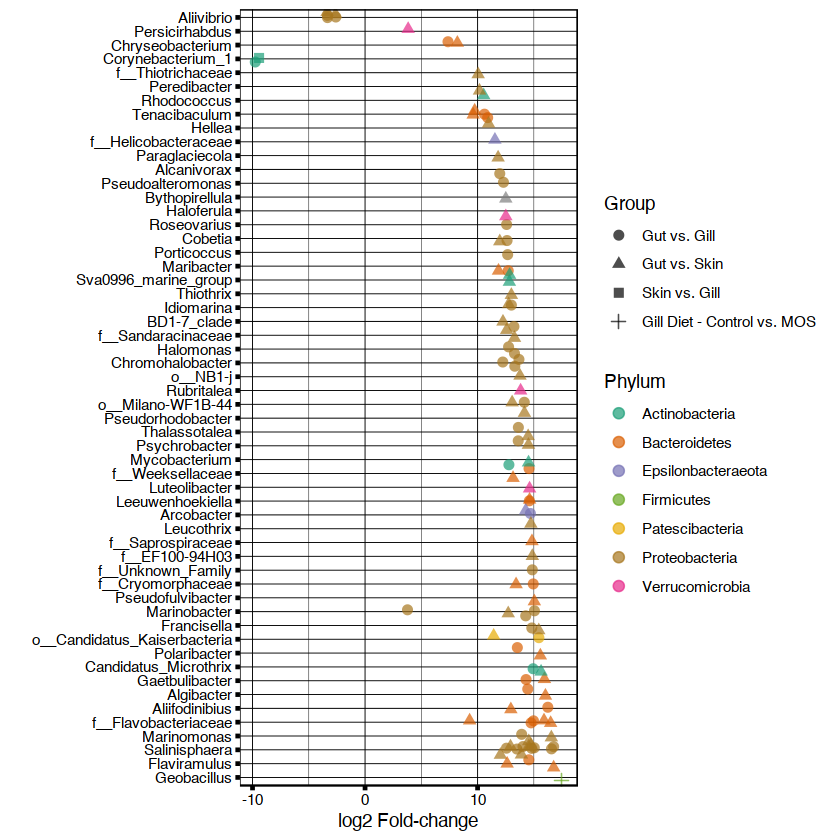

In [67]:
require('microbiomeutilities')
psFish1fbh <- format_to_besthit(psFish1f)
taxa_names(psFish1fbh) <- taxa_names(psFish1f)

sigtabSGi = subset(skinVgill, padj < 0.05)
sigtabSGi = cbind(as(sigtabSGi, "data.frame"), as(tax_table(psFish1fbh)[rownames(sigtabSGi), ], "matrix"))
sigtabSGi$Group <- 'Skin vs. Gill'
#head(sigtabSGi)

sigtabSG = subset(gillVgut, padj < 0.05)
sigtabSG = cbind(as(sigtabSG, "data.frame"), as(tax_table(psFish1fbh)[rownames(sigtabSG), ], "matrix"))
sigtabSG$Group <- 'Gut vs. Skin'
#head(sigtabSG)

sigtabGuGi = subset(skinVgut, padj < 0.05)
sigtabGuGi = cbind(as(sigtabGuGi, "data.frame"), as(tax_table(psFish1fbh)[rownames(sigtabGuGi), ], "matrix"))
sigtabGuGi$Group <- 'Gut vs. Gill'
#head(sigtabGuGi)

sigtabGillConMOS = subset(conVmosGi, padj < 0.05)
sigtabGillConMOS = cbind(as(sigtabGillConMOS, "data.frame"), as(tax_table(psGill)[rownames(sigtabGillConMOS), ], "matrix"))
sigtabGillConMOS$Group <- 'Gill Diet - Control vs. MOS'
#head(sigtabGillConMOS)

sigTabTissue <- dplyr::bind_rows(sigtabSGi, sigtabGuGi, sigtabSG, sigtabGillConMOS)
sigTabTissue <- sigTabTissue %>% filter(abs(log2FoldChange) >= 1 & padj <= 0.05)
nrow(sigTabTissue) # how many total DA microbes
table(sigTabTissue$Group) # how many DA per group

sigTabTissue$Group <- factor(sigTabTissue$Group, levels=c('Gut vs. Gill',
                                                          'Gut vs. Skin',
                                                          'Skin vs. Gill',
                                                          'Gill Diet - Control vs. MOS'))

require(RColorBrewer)
colList <- brewer.pal(n = 7, name = "Dark2")
myColorscale <- scale_colour_manual(values = c("Actinobacteria" = colList[1],
                                               "Bacteroidetes" = colList[2], 
                                               "Epsilonbacteraeota" = colList[3],
                                               "Firmicutes" = colList[5],
                                               "Patescibacteria" = colList[6],
                                               "Proteobacteria" = colList[7],
                                               "Verrucomicrobia" = colList[4]))

x = tapply(abs(sigTabTissue$log2FoldChange), sigTabTissue$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigTabTissue$Phylum = factor(as.character(sigTabTissue$Phylum), levels=names(x))
# Genus order
x = tapply(abs(sigTabTissue$log2FoldChange), sigTabTissue$Genus, function(x) max(x))
x = sort(x, TRUE)
sigTabTissue$Genus = factor(as.character(sigTabTissue$Genus), levels=names(x))
lfcTissue <-ggplot(sigTabTissue, 
                   aes(x=log2FoldChange,
                       y=Genus,
                       color=Phylum)
                  ) + geom_point(size=2.5,
                                 alpha=.7,
                                 aes(shape=Group),
                                 position ='jitter'#) + geom_vline(xintercept=1, linetype="longdash", color = "darkgrey", size=0.5
                                                               #) + geom_vline(xintercept=-1, linetype="longdash", color = "darkgrey", size=0.5
                                                               ) + xlab('log2 Fold-change') + ylab('') + myColorscale + theme(legend.position='right')+ theme_linedraw(base_line_size = 2) 
lfcTissue 
ggsave(device='tiff', width=7, height=7, 'Figures/Manuscript/LFC_Tissue.tiff')      

## Alpha Diversity

In [ ]:
require('ranacapa')
rarePlot <- ggrare(psFish1f, step = 1000, col='Tissue', label = "SampleID", se = F)
rarePlot <- rarePlot + theme_classic()
ggsave('Figures/Manuscript/RichnessRareCurve.tiff')

#### Full dataset alpha - two-way analysis

In [69]:
AlphaDataFish <- estimate_richness(psFish1f, measures=c("Shannon", "Simpson", "Observed"))
AlphaDataFish$SampleID <- row.names(AlphaDataFish)

metaDataFish <- data.frame(sample_data(psFish1f))
metaDataFish $SampleID <- row.names(metaDataFish)

AlphaDataFish <- merge(metaDataFish, AlphaDataFish, by = "SampleID", all=TRUE)
head(AlphaDataFish)

,SampleID,Tank,Fish,Tissue,Diet,Observed,Shannon,Simpson
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
1,T1_F1_Gill,T1,F1,Gill,Control,165,4.217393,0.9714539
2,T1_F1_Gut,T1,F1,Gut,Control,22,1.728477,0.7230096
3,T1_F1_Skin,T1,F1,Skin,Control,146,4.485207,0.9822465
4,T1_F2_Gill,T1,F2,Gill,Control,162,3.547739,0.9336441
5,T1_F2_Gut,T1,F2,Gut,Control,35,2.411733,0.8451116
6,T1_F2_Skin,T1,F2,Skin,Control,145,1.096921,0.3652627


In [70]:
AlphaDataFish$Tissue <- factor(AlphaDataFish$Tissue, levels= c("Gut", "Skin", "Gill"))

#### Merge data by tank (experimental unit)

In [71]:
library(plotrix)
AlphaFishTank <- group_by(AlphaDataFish, Tissue, Diet, Tank) %>%
                          summarise(
                              count = n(),
                              meanObs = mean(Observed, na.rm = TRUE),
                              sdObs = sd(Observed, na.rm = TRUE),
                              seObs = std.error(Observed, na.rm = TRUE),
                              meanShan = mean(Shannon, na.rm = TRUE),
                              sdShan = sd(Shannon, na.rm = TRUE),
                              seShan = std.error(Shannon, na.rm = TRUE),
                              meanSimp = mean(Simpson, na.rm = TRUE),
                              sdSimp = sd(Simpson, na.rm = TRUE),
                              seSimp = std.error(Simpson, na.rm = TRUE)
                          )

Warning message:
“package ‘plotrix’ was built under R version 4.0.2”

Attaching package: ‘plotrix’


The following object is masked from ‘package:gplots’:

    plotCI


`summarise()` has grouped output by 'Tissue', 'Diet'. You can override using the `.groups` argument.



In [72]:
head(AlphaFishTank)

Tissue,Diet,Tank,count,meanObs,sdObs,seObs,meanShan,sdShan,seShan,meanSimp,sdSimp,seSimp
<fct>,<fct>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gut,Control,T1,3,22.33333,12.503333,7.218803,1.7447129,0.65905213,0.38050392,0.7185758,0.12880988,0.074368417
Gut,Control,T10,3,18.66667,2.516611,1.452966,0.9521024,0.05286841,0.03052359,0.5574228,0.01083612,0.006256237
Gut,Control,T17,3,16.66667,3.511885,2.027588,1.9375077,0.54153592,0.31265591,0.7603216,0.11673619,0.067397669
Gut,Control,T18,3,16.66667,3.785939,2.185813,1.5483018,0.73384481,0.42368550,0.6812241,0.16250909,0.093824665
Gut,Control,T4,3,23.66667,11.015141,6.359595,2.3371984,0.40505746,0.23386004,0.8652305,0.05190049,0.029964761
Gut,Control,T7,3,17.00000,4.358899,2.516611,1.8559786,0.70247052,0.40557155,0.7501557,0.16891273,0.097521808


In [73]:
ann_text1 <- data.frame(Diet = 2.5, meanObs = 285,lab = "A",
                        Tissue = factor("Gut",levels = c("Gut","Skin","Gill")))
ann_text2 <- data.frame(Diet = 2.5, meanObs = 285,lab = "B",
                        Tissue = factor("Skin",levels = c("Gut","Skin","Gill")))
ann_text3 <- data.frame(Diet = 2.5, meanObs = 285,lab = "B",
                        Tissue = factor("Gill",levels = c("Gut","Skin","Gill")))

In [74]:
dat_text <- data.frame(label = c("A", "B", "B"),
                       Tissue = factor(c("Gut","Skin","Gill"),levels = c("Gut","Skin","Gill")),
                       meanObs = c(50, 200, 240), 
                       Diet = 2.5)

Warning message:
“package ‘ggpubr’ was built under R version 4.0.2”

Attaching package: ‘ggpubr’


The following object is masked from ‘package:VennDiagram’:

    rotate


Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”


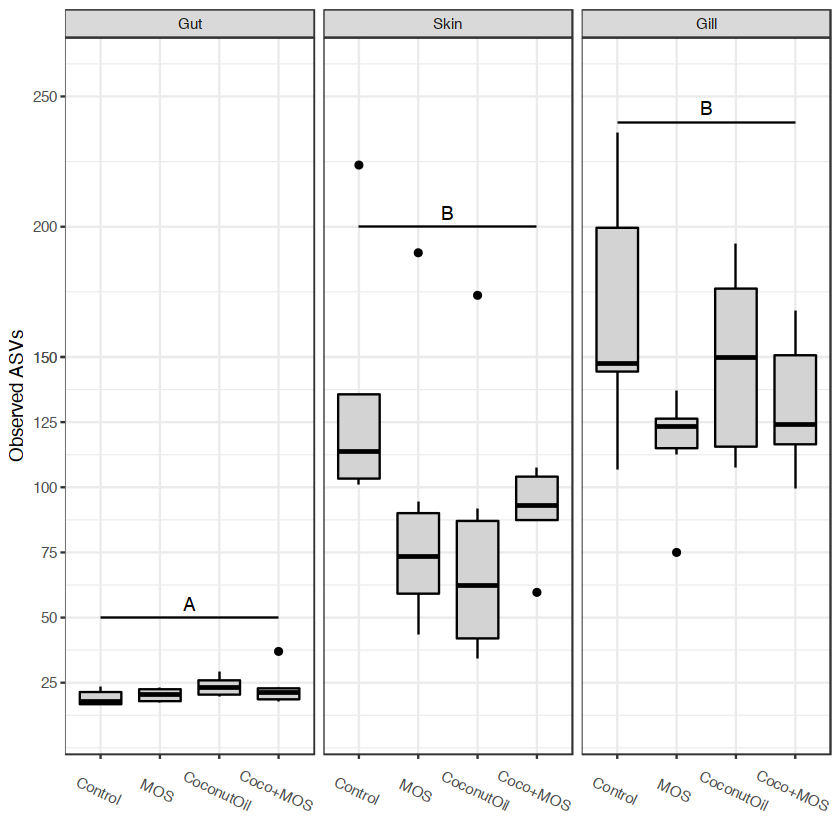

In [75]:
library('ggpubr')
obs2wayTankBox <- ggboxplot(AlphaFishTank, x = "Diet", y = "meanObs", color = "black", fill='lightgray', facet.by="Tissue") 
obs2wayTankBox <- obs2wayTankBox + ylab('Observed ASVs'
                                         ) + theme_bw() + scale_y_continuous(breaks=c(seq(25,150,25), seq(150,300,50)),
                                                                            limits=c(10,260)) + xlab(""
                                                                                    ) + theme(axis.text.x=element_text(angle = -25)
                                                                                             ) + geom_text(data = dat_text,
                                                                                                           mapping = aes(x = Diet, y = meanObs, label = label),
                                                                                                           vjust = -0.5
                                                                                                          ) + geom_segment(data = dat_text,
                                                                                                                           mapping = aes(x = 1, 
                                                                                                                                         xend = 4,
                                                                                                                                         y = meanObs,
                                                                                                                                         yend = meanObs))
obs2wayTankBox
#ggsave('Figures/Manuscript/ObsTwoWay.tiff',  scale=0.9)

In [76]:
fishTankObs <- lm(meanObs ~ Tissue * Diet, data = AlphaFishTank)
#plot(fishTankObs)
Anova(fishTankObs, type="II")
summary(glht(fishTankObs, linfct = mcp(Tissue = "Tukey"))) # can ignore error 
summary(glht(fishTankObs, linfct = mcp(Diet = "Dunnett")))

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Tissue,193246.48,2,61.741046,2.733550e-15
Diet,15459.68,3,3.292848,2.650975e-02
Tissue:Diet,16589.19,6,1.766715,1.213705e-01
Residuals,93898.55,60,NA,NA


Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = meanObs ~ Tissue * Diet, data = AlphaFishTank)

Linear Hypotheses:
                 Estimate Std. Error t value Pr(>|t|)    
Skin - Gut == 0   138.000     22.840   6.042   <1e-04 ***
Gill - Gut == 0   147.167     22.840   6.443   <1e-04 ***
Gill - Skin == 0    9.167     22.840   0.401    0.915    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Dunnett Contrasts


Fit: lm(formula = meanObs ~ Tissue * Diet, data = AlphaFishTank)

Linear Hypotheses:
                          Estimate Std. Error t value Pr(>|t|)
MOS - Control == 0           1.111     22.840   0.049    1.000
CoconutOil - Control == 0    4.444     22.840   0.195    0.995
Coco+MOS - Control == 0      3.917     22.840   0.171    0.996
(Adjusted p values reported -- single-step method)


In [77]:
skinObs <- lm(meanObs ~  Diet, data = AlphaFishTank %>% filter(Tissue == 'Skin'))
Anova(skinObs, type="II")
gillObs <- lm(meanObs ~  Diet, data = AlphaFishTank %>% filter(Tissue == 'Gill'))
Anova(gillObs, type="II")
gutObs <- lm(meanObs ~  Diet, data = AlphaFishTank %>% filter(Tissue == 'Gut'))
Anova(gutObs, type="II")

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Diet,23722.24,3,2.951251,0.05745298
Residuals,53586.85,20,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Diet,8243.253,3,1.377383,0.2784909
Residuals,39898.134,20,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Diet,83.3831,3,1.344151,0.2883343
Residuals,413.5602,20,NA,NA


In [78]:
dat_text2 <- data.frame(label = c("A", "B", "B"),
                        Tissue = factor(c("Gut","Skin","Gill"),levels = c("Gut","Skin","Gill")),
                        yVal = c(2.62, 2.1, 2.8), 
                        Diet = 2.5)

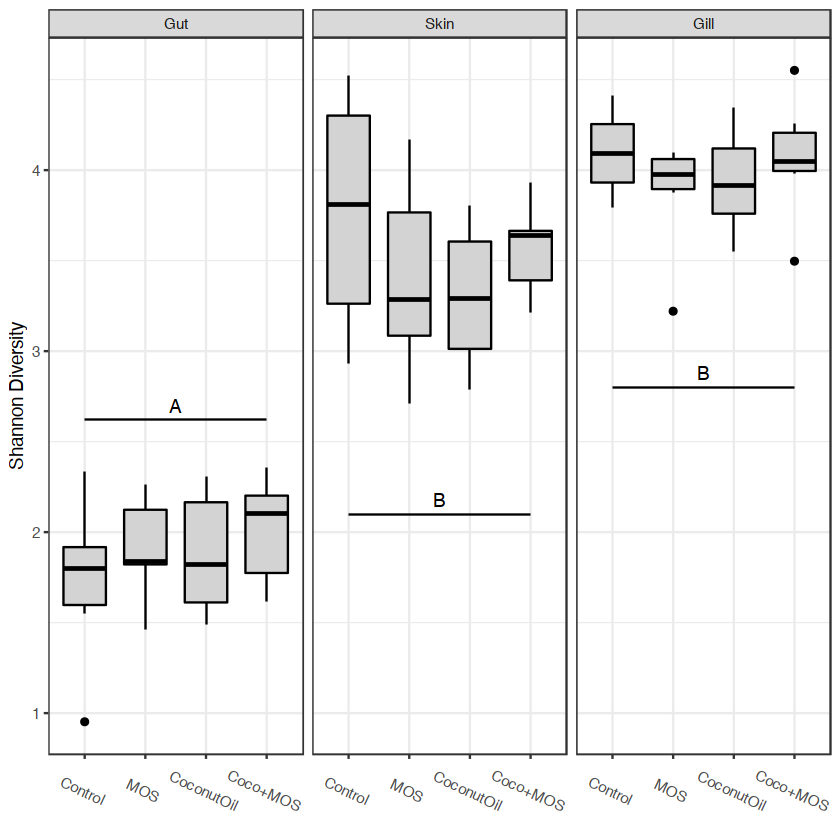

In [79]:
sha2wayTankBox <- ggboxplot(AlphaFishTank, x = "Diet", y = "meanShan", color = "black", fill='lightgray', facet.by="Tissue") 
sha2wayTankBox <- sha2wayTankBox + ylab('Shannon Diversity'
                                     )+ theme_bw() + xlab(""
                                                         ) + theme(axis.text.x=element_text(angle = -25)
                                                                  ) + geom_text(data = dat_text2,
                                                                                mapping = aes(x = Diet, y = yVal, label = label),
                                                                                vjust = -0.5
                                                                               ) + geom_segment(data = dat_text2,
                                                                                                mapping = aes(x = 1, xend=4, y = yVal, yend=yVal))
sha2wayTankBox
#ggsave('Figures/Manuscript/ShannonTwoWay.tiff', scale=0.9)

In [80]:
fishTankShan <- lm(meanShan ~ Tissue * Diet, data = AlphaFishTank)
#plot(fishTankShan)
Anova(fishTankShan, type="II")
summary(glht(fishTankShan, linfct = mcp(Tissue = "Tukey"))) # can ignore error - only Tissue was significant

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Tissue,58.6919631,2,190.9345017,9.676792e-27
Diet,0.4553156,3,0.9874772,4.048451e-01
Tissue:Diet,0.7522969,6,0.8157814,5.619682e-01
Residuals,9.2217953,60,NA,NA


Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = meanShan ~ Tissue * Diet, data = AlphaFishTank)

Linear Hypotheses:
                 Estimate Std. Error t value Pr(>|t|)    
Skin - Gut == 0    2.0403     0.2263   9.014   <1e-04 ***
Gill - Gut == 0    2.3669     0.2263  10.457   <1e-04 ***
Gill - Skin == 0   0.3266     0.2263   1.443    0.326    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


In [81]:
dat_text3 <- data.frame(label = c("A", "B", "B"),
                        Tissue = factor(c("Gut","Skin","Gill"),levels = c("Gut","Skin","Gill")),
                        yVal = .982, 
                        Diet = 2.5)

In [82]:
sim2wayTankBox <- ggboxplot(AlphaFishTank, x = "Diet", y = "meanSimp", color = "black", fill='lightgray', facet.by="Tissue") 
sim2wayTankBox <- sim2wayTankBox + ylab('Simpson Index'
                                 )+ theme_bw() + xlab(""
                                                     ) + theme(axis.text.x=element_text(angle = -25)
                                                              ) + geom_text(data = dat_text3,
                                                                            mapping = aes(x = Diet, y = yVal, label = label),
                                                                            hjust = -0.1,
                                                                            vjust = -1
                                                                           ) + geom_segment(x = 1.25, xend = 3.75,
                                                                                            y = .985, yend = .985)
#ggsave('Figures/Manuscript/SimpsonTwoWay.tiff', scale=0.9)

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Saving 8.4 x 8.4 in image



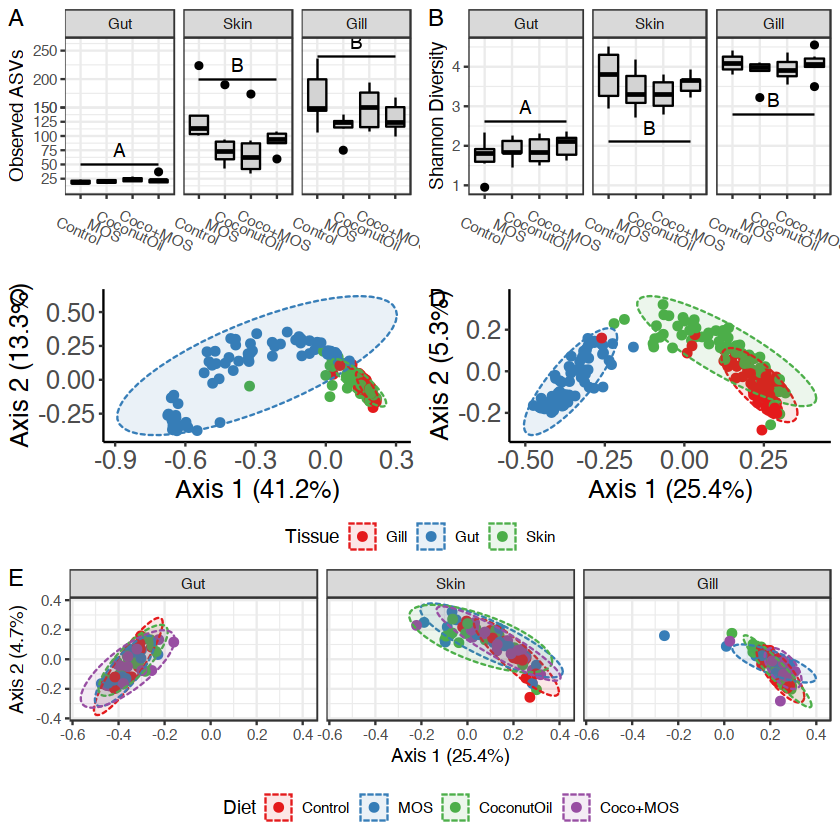

In [83]:
alphaPlots <- ggarrange(obs2wayTankBox, sha2wayTankBox, labels='AUTO')
uniFracPlots <- ggarrange(p1wUni, p1uwUni, common.legend=TRUE, legend='bottom', labels=c('C', 'D'))
ggarrange(alphaPlots, uniFracPlots, p2uw, nrow=3, labels=c('','', 'E'))
ggsave('Figures/Manuscript/MultiPlot.tiff', scale=1.2, bg = 'white')  

In [84]:
fishTankSimp <- lm(meanSimp ~ Tissue * Diet, data = AlphaFishTank)
#plot(fishTankSimp)
Anova(fishTankSimp, type="III")
summary(glht(fishTankSimp, linfct = mcp(Tissue = "Tukey"))) # can ignore error - only Tissue was significant

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.129047685,1,924.3384181,3.753726e-38
Tissue,0.185016720,2,27.3274938,3.653835e-09
Diet,0.010997578,3,1.0829156,3.632609e-01
Tissue:Diet,0.007899337,6,0.3889181,8.833112e-01
Residuals,0.203110525,60,NA,NA


Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = meanSimp ~ Tissue * Diet, data = AlphaFishTank)

Linear Hypotheses:
                 Estimate Std. Error t value Pr(>|t|)    
Skin - Gut == 0   0.18370    0.03359   5.469   <1e-04 ***
Gill - Gut == 0   0.23657    0.03359   7.043   <1e-04 ***
Gill - Skin == 0  0.05287    0.03359   1.574    0.265    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


# Plot compositions

### Environmental samples

In [85]:
psDietWater_Merged <- merge_samples(psDietWater, 'Diet')
psDietWater_Merged <- tax_glom(psDietWater_Merged, taxrank = 'Phylum', NArm = FALSE)
psDietWater_Mergedr <- transform_sample_counts(psDietWater_Merged, function(x) x / sum(x))
psDietWaterglom <- tax_glom(psDietWater, taxrank = 'Phylum', NArm = FALSE)                                               
psDietWaterR <- transform_sample_counts(psDietWaterglom , function(x) x / sum(x))                                       

Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”


In [86]:
length(table(tax_table(psDietWaterR)[,'Phylum']))

[1] 27

In [87]:
sample_data(psDietWaterR)$Diet <- factor(sample_data(psDietWaterR)$Diet, levels = c("Water", "Control", "MOS", "CoconutOil", "Coco+MOS"))
levels(sample_data(psDietWaterR)$Diet)
#levels(sample_data(psDietWaterR)$Diet) <- c('Water','Control\nDiet','MOS\nDiet','CoconutOil\nDiet','Coco+MOS\nDiet')
#levels(sample_data(psDietWaterR)$Diet)

[1] "Water"      "Control"    "MOS"        "CoconutOil" "Coco+MOS"

In [88]:
library('RColorBrewer')
library(viridis)
getPalette = colorRampPalette(brewer.pal(8,'Dark2'))
phylumList = unique(tax_table(ps)[,"Phylum"])
phylumPalette = getPalette(length(phylumList))
names(phylumPalette) = phylumList

In [89]:
p = plot_bar(psDietWaterR,
             fill="Phylum") + scale_fill_manual(values=phylumPalette
                                 ) + facet_grid(~Diet, 
                                                scales="free_x") 

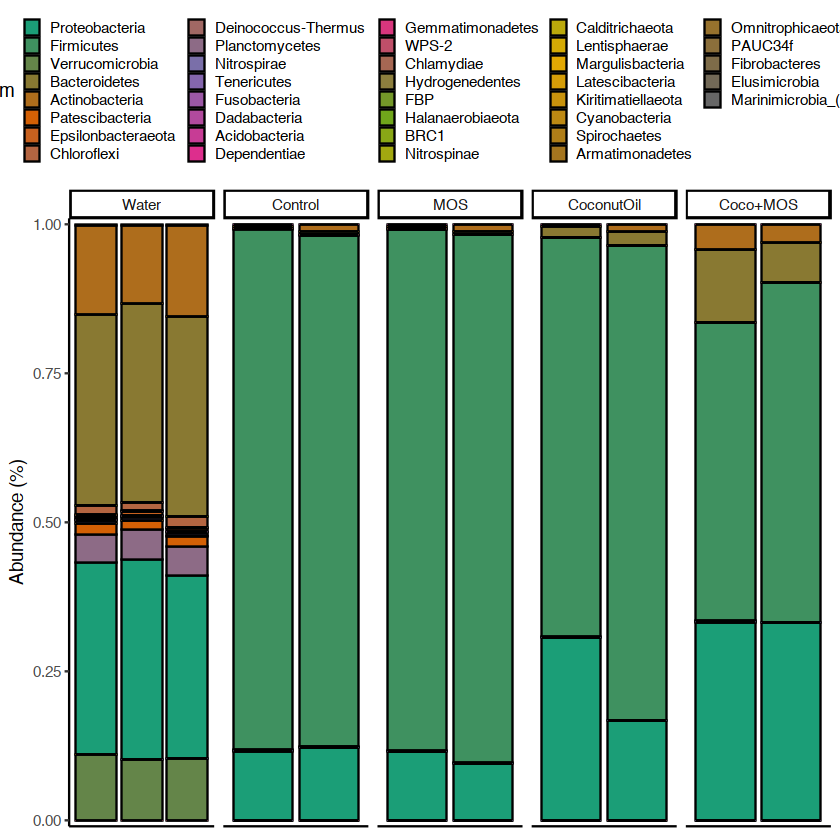

In [90]:
DietWaterP <- p + theme_classic() + theme(axis.text.x = element_blank(),
                                          #strip.text = element_text(face="bold", size=10),
                                          #strip.background = element_rect(fill="white", colour="black",size=1),
                                          legend.position='bottom'
                                          ) + scale_y_continuous(expand=c(0,0.01)#, 
                                                                ) + ylab('Abundance (%)'
                                                                        ) + xlab(""
                                                                                ) + theme(legend.key.size = unit(0.75,'lines'))+ theme(legend.position="top",
                                                                             axis.title.x = element_blank(),
                                                                              axis.text.x = element_blank(),
                                                                              axis.ticks.x = element_blank())
DietWaterP #+ scale_fill_viridis_d()
#ggsave('Figures/Manuscript/EnviroPhyla.tiff', scale = 1.2)

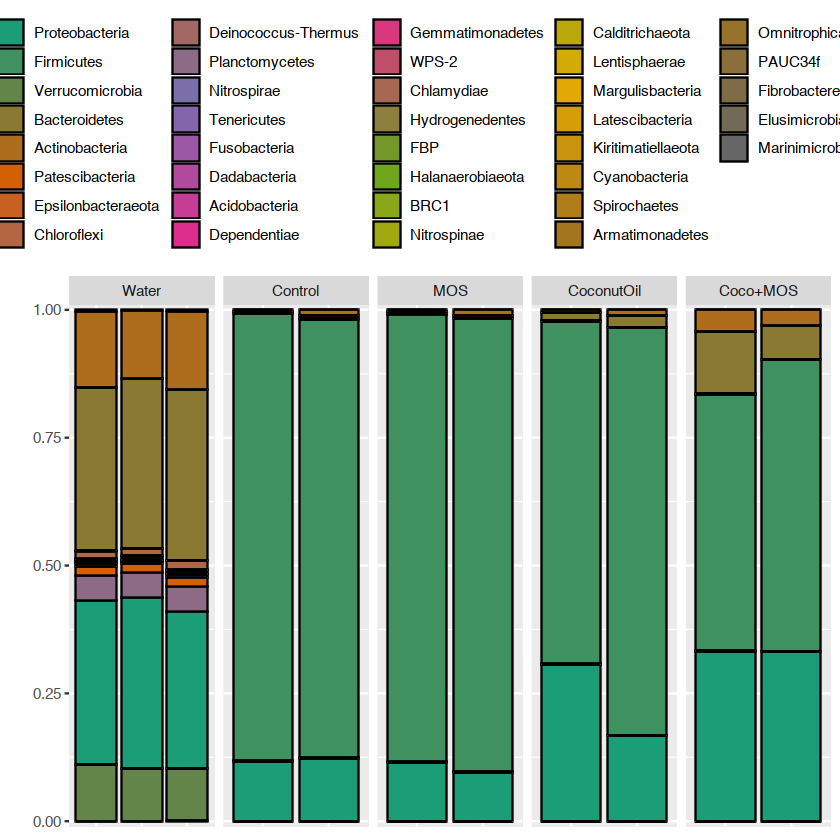

In [91]:
p2 <- p + scale_y_continuous(expand=c(0,0.01)) + xlab("") + ylab("") + theme(legend.position="top",
                                                                             axis.title.x = element_blank(),
                                                                              axis.text.x = element_blank(),
                                                                              axis.ticks.x = element_blank())
p2

## Skin Phyla

In [92]:
psSkin
length(table(tax_table(psSkin)[,'Phylum']))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1604 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 1604 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1604 tips and 1603 internal nodes ]
refseq()      DNAStringSet:      [ 1604 reference sequences ]

[1] 29

In [93]:
skinPlotOrder <- arrange(data.frame(sample_data(psSkin)), Diet)
skinPlotOrder <- skinPlotOrder[,'SampleID']

In [94]:
psSkinP <- tax_glom(psSkin, taxrank = 'Phylum', NArm = FALSE)
psSkinPr  <- transform_sample_counts(psSkinP, function(x) x / sum(x))

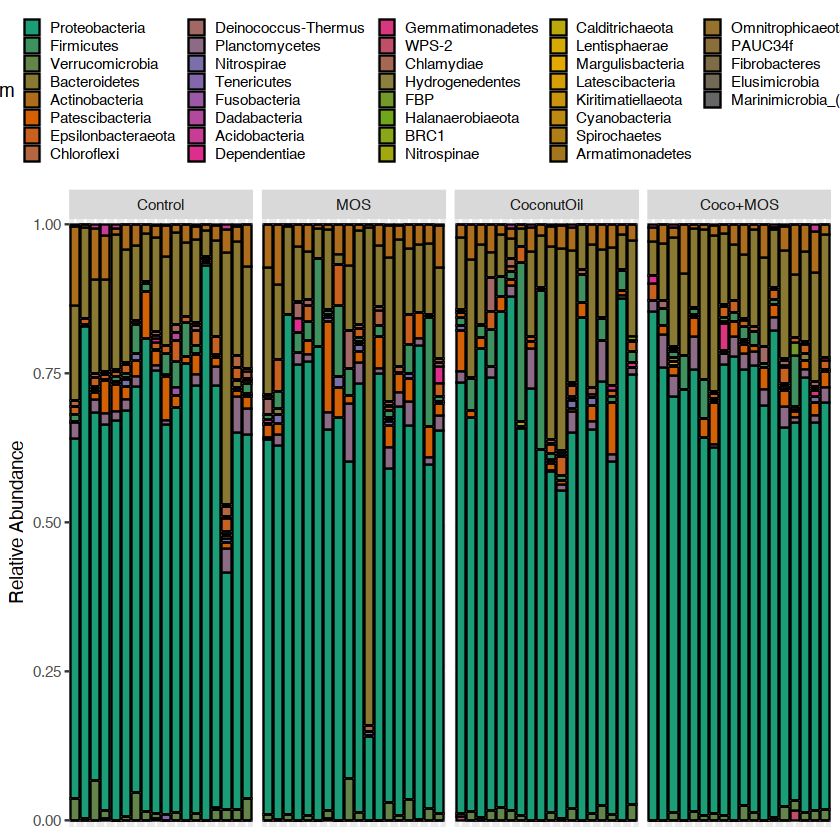

In [95]:
plotSkin = plot_bar(psSkinPr, fill="Phylum") + scale_fill_manual(values=phylumPalette) + theme(legend.key.size = unit(0.75,'lines'))
plotSkin$data$Sample <- factor(plotSkin$data$Sample, levels = skinPlotOrder)
plotSkin <- plotSkin + facet_grid(~Diet, scales="free_x") + scale_y_continuous(expand=c(0,0.01)) + xlab("") + ylab("Relative Abundance") + theme(legend.position="top",
                                                                                                                                                 axis.title.x = element_blank(),
                                                                                                                                                  axis.text.x = element_blank(),
                                                                                                                                                  axis.ticks.x = element_blank())
plotSkin
#ggsave('Figures/Manuscript/SkinPhylaBar.pdf', scale = 1.5)#, width = 18, height = 10)

## Gill Phyla

In [96]:
gillPlotOrder <- arrange(data.frame(sample_data(psGill)), Diet)
gillPlotOrder <- gillPlotOrder[,'SampleID']

In [97]:
psGillP <- tax_glom(psGill, taxrank = 'Phylum', NArm = FALSE)
psGillPr  <- transform_sample_counts(psGillP, function(x) x / sum(x))
length(table(tax_table(psGillPr)[,'Phylum']))

[1] 31

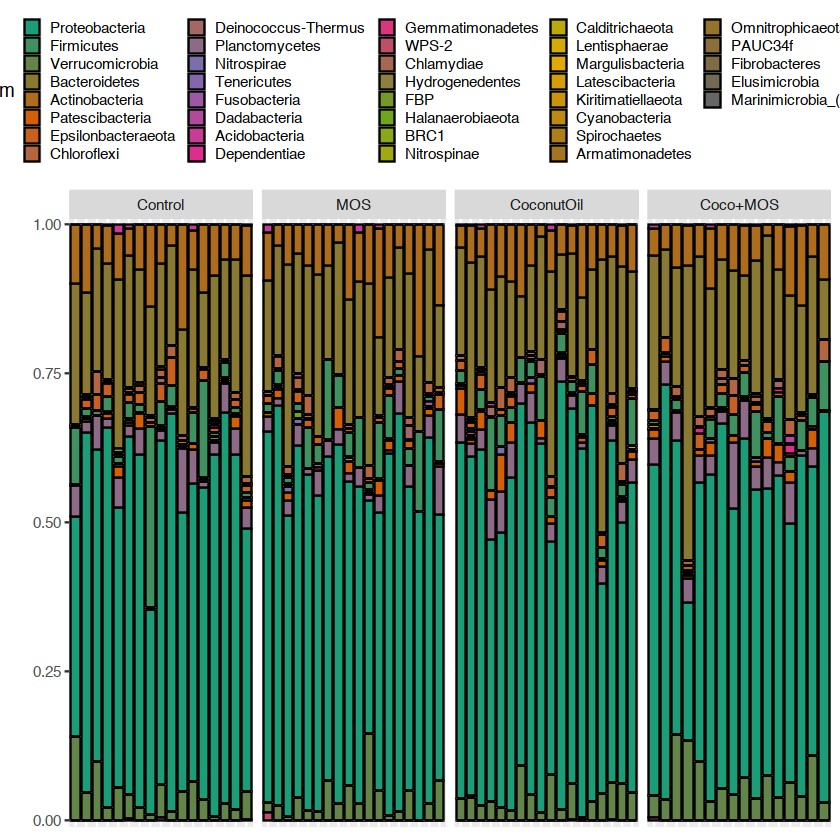

In [98]:
plotGill = plot_bar(psGillPr, fill="Phylum") + scale_fill_manual(values=phylumPalette) + theme(legend.key.size = unit(0.75,'lines'))
plotGill$data$Sample <- factor(plotGill$data$Sample, levels = gillPlotOrder)
plotGill <- plotGill + facet_grid(~Diet, scales="free_x") + scale_y_continuous(expand=c(0,0.01)) + xlab("") + ylab("") + theme(legend.position="top",
                                                                                                                                 axis.title.x = element_blank(),
                                                                                                                                  axis.text.x = element_blank(),
                                                                                                                                  axis.ticks.x = element_blank())
plotGill
#ggsave('Figures/Manuscript/GillPhylaBar.pdf', scale = 1.5)#, width = 18, height = 10)

## Gut Phyla

In [99]:
gutPlotOrder <- arrange(data.frame(sample_data(psGut)), Diet)
gutPlotOrder <- gutPlotOrder[,'SampleID']

In [100]:
psGutP <- tax_glom(psGut, taxrank = 'Phylum', NArm = FALSE)
psGutPr  <- transform_sample_counts(psGutP, function(x) x / sum(x))
length(unique(tax_table(psGillPr)[,'Phylum']))                           

[1] 31

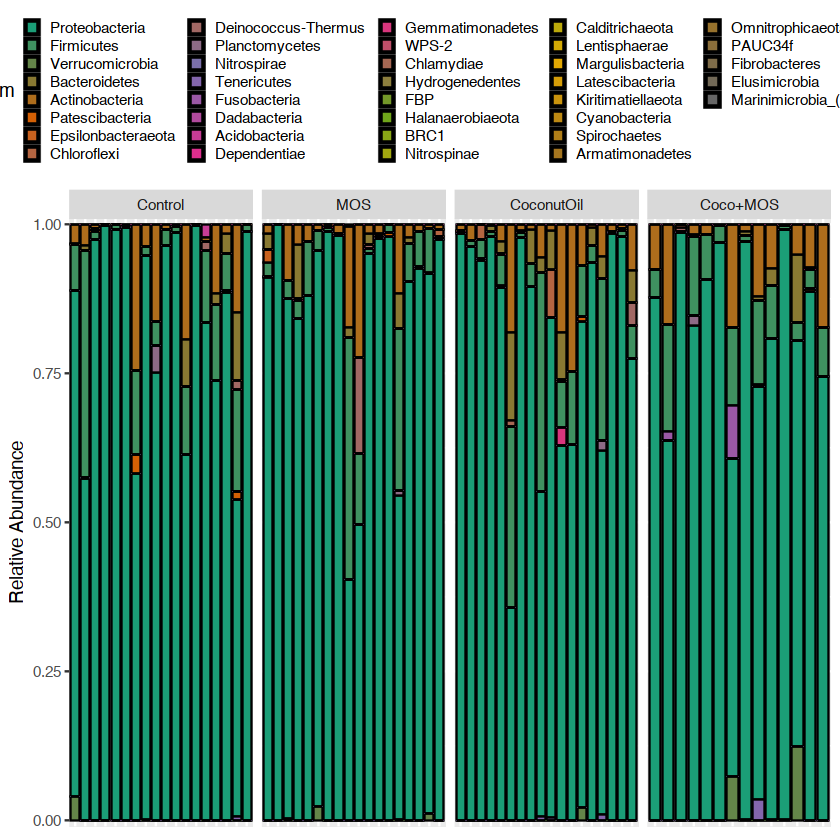

In [101]:
plotGut = plot_bar(psGutPr, fill="Phylum") + scale_fill_manual(values=phylumPalette) + guides(fill = guide_legend(override.aes = list(size=1))) + theme(legend.key.size = unit(0.75,'lines'))
plotGut$data$Sample <- factor(plotGut$data$Sample, levels = gutPlotOrder)
plotGut <- plotGut + facet_grid(~Diet, scales="free_x") + scale_y_continuous(expand=c(0,0.01)) + xlab("") + ylab("Relative Abundance") + theme(legend.position="top",
                                                                                                                                                 axis.title.x = element_blank(),
                                                                                                                                                  axis.text.x = element_blank(),
                                                                                                                                                  axis.ticks.x = element_blank())
plotGut
#ggsave('Figures/Manuscript/GutPhylaBar.pdf', scale = 1.5)#, width = 18, height = 10)

In [102]:
PhyPlot <- ggarrange(plotSkin, plotGill, plotGut, p2, ncol=2, nrow=2, common.legend = TRUE, legend = 'top', labels = 'AUTO', label.x = ) + guides(fill = guide_legend(override.aes = list(size=1)))

Loading required package: cowplot

Warning message:
“package ‘cowplot’ was built under R version 4.0.2”

Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


Saving 8.26 x 8.26 in image



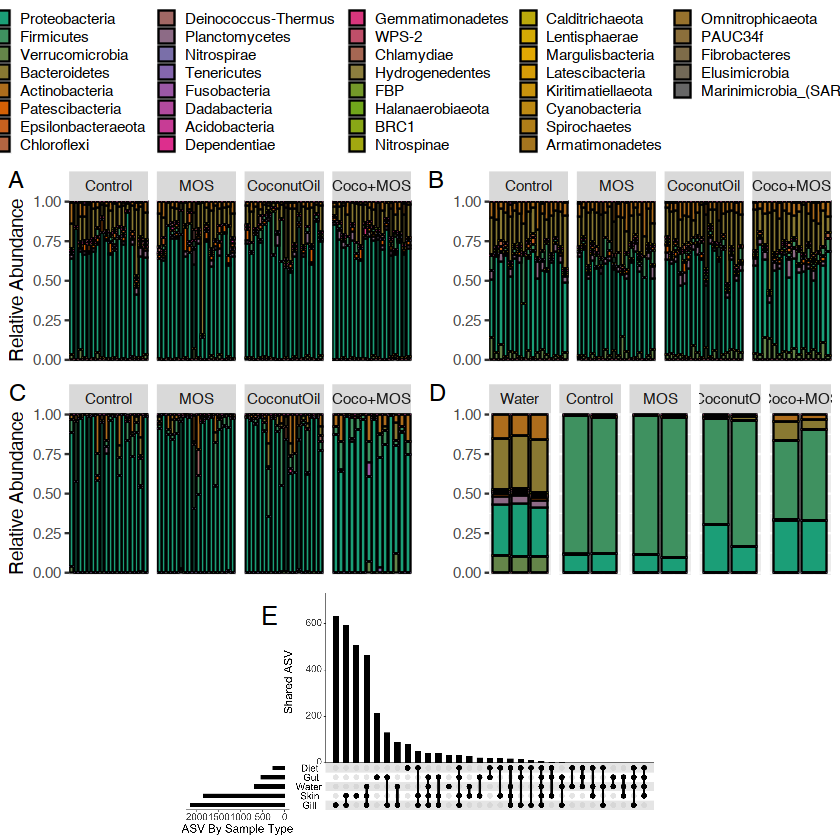

In [103]:
upSetPlot <- png::readPNG('/Users/jakebledsoe/Desktop/NCWMAC\ Projects/Functional\ Feed\ Study/MicroAnalysis/NCWMAC_Micro/Figures/Manuscript/upSetPlot.png')

upSetPlotFig <- ggarrange(rasterGrob(upSetPlot))
#ggarrange(lfcTissue ,upSetPlotFig, ncol=1)
require('cowplot')
ggdraw() + draw_plot(PhyPlot, x=0, y=0.3, height=0.7, width=1) +
  draw_plot(upSetPlotFig, x=0, y=0, height=0.3, width=1) +
  draw_plot_label(label = "E", size = 15,
                  x = 0.3, y = .29)
ggsave('Figures/Manuscript/CompostionPlot.tiff', scale=1.18, bg='white')   